# 22256520 LI Yikuan ISEM4037 Assignment 2
# Cryptocurrency Price Prediction using ARIMAX, XGBoost, LSTM and GRU

Description: 

In this assignment, I will use ARIMAX, XGBoost, LSTM and GRU to predict the cryptocurrency price for the next 10 days. To make better predictions, all the models I used include exogenous variables (e.g. volume, SP500 Index, range).

After using all models to make predictions, to make a robust prediction, the final prediction price takes a weighted average of prices predicted by different models (if the model has acceptable performance), where the weight of a single model is inversely proportional to its MAE score.

# Inspect the dataset and preprocessing

In [882]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("CryptoA-Fiat-CryptoB.csv")

# Try SP500
df_SP500 = pd.read_csv('SP500.csv')
df.head(10)

,obs,low (fiat),high (fiat),open (fiat),close (fiat),vol (fiat),trade_vol (fiat),low (crypto),high (crypto),open (crypto),close (crypto),vol (crypto),trade_vol (crypto),Unnamed: 13
0,1,69.103,72.883,71.188,70.718,3671.094246,2.596124e+05,0.00835457,0.008648,0.008566,0.008450,635.047788,5.366243,NaN
1,2,69.012,70.998,70.691,70.969,1455.866969,1.033214e+05,0.00838294,0.008520,0.008447,0.008459,348.847022,2.950890,NaN
2,3,68.006,71.232,71.109,69.297,2087.604971,1.446648e+05,0.00836785,0.008548,0.008444,0.008439,458.127542,3.866299,NaN
3,4,68.002,70.573,69.328,69.864,1770.263955,1.236777e+05,0.00841485,0.008565,0.008452,0.008562,239.334295,2.049152,NaN
4,5,68.341,70.350,69.846,70.214,1541.626939,1.082438e+05,0.00850048,0.008616,0.008550,0.008575,209.179333,1.793736,NaN
5,6,68.000,71.405,70.215,69.537,2260.409072,1.571821e+05,0.00856453,0.008911,0.008579,0.008800,749.712686,6.597224,NaN
6,7,68.002,72.429,69.156,71.007,2564.572648,1.821026e+05,0.00858548,0.008881,0.008820,0.008622,456.307146,3.934340,NaN
7,8,69.902,104.036,71.260,71.058,23120.583030,1.642902e+06,0.00858548,0.012890,0.008633,0.008653,5007.463511,43.332085,NaN
8,9,70.308,74.752,70.669,73.698,11059.780850,8.150837e+05,0.008535,0.008763,0.008631,0.008626,2649.597423,22.854659,NaN
9,10,70.701,74.990,74.373,72.603,4254.419599,3.088836e+05,0.00833404,0.008713,0.008669,0.008504,712.814358,6.061581,NaN


In [883]:
# Align the index of SP500 & Cryptocurrency
import pandas as pd

# Read the SP500.csv file
df_SP500 = pd.read_csv('SP500.csv')

# Convert the 'Date' column to datetime format
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])

# Create a date range including weekends
date_range = pd.date_range(start=df_SP500['Date'].iloc[0], end=df_SP500['Date'].iloc[-1], freq='D')

# Reindex the DataFrame with the date range including weekends
df_SP500 = df_SP500.set_index('Date').reindex(date_range).ffill().reset_index()

# Save the updated DataFrame to a new CSV file
df_SP500.to_csv('SP500_imputed.csv', index=False)
df_SP500

,index,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,8026.830078,8062.500000,7906.290039,7908.680176,7908.680176,2.250500e+09
1,2019-10-02,7851.129883,7852.700195,7744.959961,7785.250000,7785.250000,2.503630e+09
2,2019-10-03,7787.020020,7872.259766,7700.000000,7872.259766,7872.259766,2.157220e+09
3,2019-10-04,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09
4,2019-10-05,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09
...,...,...,...,...,...,...,...
1608,2024-02-25,16094.799805,16134.219727,15954.500000,15996.820313,15996.820313,5.077910e+09
1609,2024-02-26,16014.450195,16054.900391,15973.900391,15976.250000,15976.250000,5.417630e+09
1610,2024-02-27,16013.980469,16046.099609,15940.509766,16035.299805,16035.299805,5.423020e+09
1611,2024-02-28,15969.139648,16003.559570,15924.719727,15947.740234,15947.740234,5.581690e+09


In [884]:
# Modify obs
start_date = pd.to_datetime('2019-10-01')
df['obs'] = start_date + pd.to_timedelta(df.index, unit='D')
df.head(10)

,obs,low (fiat),high (fiat),open (fiat),close (fiat),vol (fiat),trade_vol (fiat),low (crypto),high (crypto),open (crypto),close (crypto),vol (crypto),trade_vol (crypto),Unnamed: 13
0,2019-10-01,69.103,72.883,71.188,70.718,3671.094246,2.596124e+05,0.00835457,0.008648,0.008566,0.008450,635.047788,5.366243,NaN
1,2019-10-02,69.012,70.998,70.691,70.969,1455.866969,1.033214e+05,0.00838294,0.008520,0.008447,0.008459,348.847022,2.950890,NaN
2,2019-10-03,68.006,71.232,71.109,69.297,2087.604971,1.446648e+05,0.00836785,0.008548,0.008444,0.008439,458.127542,3.866299,NaN
3,2019-10-04,68.002,70.573,69.328,69.864,1770.263955,1.236777e+05,0.00841485,0.008565,0.008452,0.008562,239.334295,2.049152,NaN
4,2019-10-05,68.341,70.350,69.846,70.214,1541.626939,1.082438e+05,0.00850048,0.008616,0.008550,0.008575,209.179333,1.793736,NaN
5,2019-10-06,68.000,71.405,70.215,69.537,2260.409072,1.571821e+05,0.00856453,0.008911,0.008579,0.008800,749.712686,6.597224,NaN
6,2019-10-07,68.002,72.429,69.156,71.007,2564.572648,1.821026e+05,0.00858548,0.008881,0.008820,0.008622,456.307146,3.934340,NaN
7,2019-10-08,69.902,104.036,71.260,71.058,23120.583030,1.642902e+06,0.00858548,0.012890,0.008633,0.008653,5007.463511,43.332085,NaN
8,2019-10-09,70.308,74.752,70.669,73.698,11059.780850,8.150837e+05,0.008535,0.008763,0.008631,0.008626,2649.597423,22.854659,NaN
9,2019-10-10,70.701,74.990,74.373,72.603,4254.419599,3.088836e+05,0.00833404,0.008713,0.008669,0.008504,712.814358,6.061581,NaN


In [885]:
# Rename columns to avoid parenthesis
df.columns.values[1] = "low_fiat"
df.columns.values[2] = "high_fiat"
df.columns.values[3] = "open_fiat"
df.columns.values[4] = "close_fiat"
df.columns.values[5] = "vol_fiat"
df.columns.values[6] = "trade_vol_fiat"
df.columns.values[7] = "low_crypto"
df.columns.values[8] = "high_crypto"
df.columns.values[9] = "open_crypto"
df.columns.values[10] = "close_crypto"
df.columns.values[11] = "vol_crypto"
df.columns.values[12] = "trade_vol_crypto"
df = df.iloc[:, :-1]
df.head()

,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto
0,2019-10-01,69.103,72.883,71.188,70.718,3671.094246,259612.4429,0.00835457,0.008648,0.008566,0.008450,635.047788,5.366243
1,2019-10-02,69.012,70.998,70.691,70.969,1455.866969,103321.4229,0.00838294,0.008520,0.008447,0.008459,348.847022,2.950890
2,2019-10-03,68.006,71.232,71.109,69.297,2087.604971,144664.7617,0.00836785,0.008548,0.008444,0.008439,458.127542,3.866299
3,2019-10-04,68.002,70.573,69.328,69.864,1770.263955,123677.7209,0.00841485,0.008565,0.008452,0.008562,239.334295,2.049152
4,2019-10-05,68.341,70.350,69.846,70.214,1541.626939,108243.7939,0.00850048,0.008616,0.008550,0.008575,209.179333,1.793736


In [886]:
# Merge original data with SP500
import pandas as pd

df = pd.merge(df, df_SP500.drop(columns='index'), how='right', left_index=True, right_index=True)
df.columns.values[13] = "SP500_open"
df.columns.values[14] = "SP500_high"
df.columns.values[15] = "SP500_low"
df.columns.values[16] = "SP500_close"
df.columns.values[17] = "SP500_adj_close"
df.columns.values[18] = "SP500_volume"
df


,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume
0,2019-10-01,69.103,72.883,71.188,70.718,3671.094246,2.596124e+05,0.00835457,0.008648,0.008566,0.008450,635.047788,5.366243,8026.830078,8062.500000,7906.290039,7908.680176,7908.680176,2.250500e+09
1,2019-10-02,69.012,70.998,70.691,70.969,1455.866969,1.033214e+05,0.00838294,0.008520,0.008447,0.008459,348.847022,2.950890,7851.129883,7852.700195,7744.959961,7785.250000,7785.250000,2.503630e+09
2,2019-10-03,68.006,71.232,71.109,69.297,2087.604971,1.446648e+05,0.00836785,0.008548,0.008444,0.008439,458.127542,3.866299,7787.020020,7872.259766,7700.000000,7872.259766,7872.259766,2.157220e+09
3,2019-10-04,68.002,70.573,69.328,69.864,1770.263955,1.236777e+05,0.00841485,0.008565,0.008452,0.008562,239.334295,2.049152,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09
4,2019-10-05,68.341,70.350,69.846,70.214,1541.626939,1.082438e+05,0.00850048,0.008616,0.008550,0.008575,209.179333,1.793736,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2024-02-25,29.720,31.010,30.450,30.940,6987.398035,2.161901e+05,0.000577,0.000602,0.000585,0.000602,49.096094,0.029556,16094.799805,16134.219727,15954.500000,15996.820313,15996.820313,5.077910e+09
1609,2024-02-26,29.950,33.090,30.940,31.810,27156.757600,8.638565e+05,0.000576,0.000604,0.000604,0.000582,247.412429,0.143994,16014.450195,16054.900391,15973.900391,15976.250000,15976.250000,5.417630e+09
1610,2024-02-27,31.300,32.930,31.910,32.090,20377.463480,6.539128e+05,0.00056,0.000583,0.000582,0.000565,183.169281,0.103491,16013.980469,16046.099609,15940.509766,16035.299805,16035.299805,5.423020e+09
1611,2024-02-28,28.610,33.030,32.090,31.250,34304.551080,1.072017e+06,0.000477,0.000561,0.000558,0.000511,498.228475,0.254595,15969.139648,16003.559570,15924.719727,15947.740234,15947.740234,5.581690e+09


In [887]:
# Inspect data types
df.dtypes

obs                 datetime64[ns]
low_fiat                   float64
high_fiat                  float64
open_fiat                  float64
close_fiat                 float64
vol_fiat                   float64
trade_vol_fiat             float64
low_crypto                  object
high_crypto                float64
open_crypto                float64
close_crypto               float64
vol_crypto                 float64
trade_vol_crypto           float64
SP500_open                 float64
SP500_high                 float64
SP500_low                  float64
SP500_close                float64
SP500_adj_close            float64
SP500_volume               float64
dtype: object

In [888]:
# Convert low_crypto into float64 (This code will report an error)
#df = pd.to_numeric(df['low_crypto'])

In [889]:
# Check position 717
df[710: 720]

,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume
710,2021-09-10,187.183,214.830,202.767,193.093,17287.471990,3338089.829,0.00416669,0.004631,0.004379,0.004298,1722.219151,7.402150,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
711,2021-09-11,191.746,203.830,193.087,193.996,10454.383620,2028108.605,0.00426329,0.004455,0.004302,0.004301,1019.087998,4.382833,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
712,2021-09-12,189.152,206.570,193.964,203.581,8550.129249,1740643.863,0.00422486,0.004477,0.004301,0.004420,675.926399,2.987601,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
713,2021-09-13,186.679,214.715,203.600,196.834,15090.255500,2970275.351,0.00423311,0.004636,0.004430,0.004380,1750.637589,7.667127,15211.429688,15215.440430,15030.849609,15105.580078,15105.580078,4.723370e+09
714,2021-09-14,194.751,208.000,196.605,205.836,12376.579330,2547545.582,0.00423484,0.004459,0.004353,0.004366,721.485187,3.150271,15168.450195,15181.190430,15008.299805,15037.759766,15037.759766,4.593140e+09
715,2021-09-15,202.708,209.790,205.840,208.964,11264.918280,2353962.384,0.00425665,0.004401,0.004368,0.004346,566.613704,2.462741,15071.339844,15174.379883,14984.679688,15161.530273,15161.530273,4.465140e+09
716,2021-09-16,202.264,220.163,209.065,208.188,18471.494720,3845543.543,0.00430774,0.004592,0.004348,0.004364,1005.702664,4.388997,15120.089844,15205.500000,15047.139648,15181.919922,15181.919922,3.701500e+09
717,2021-09-17,194.727,209.474,208.157,199.387,8579.444125,1710629.626,0.00415518(crypto),0.004362,0.004351,0.004213,786.698145,3.314391,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09
718,2021-09-18,195.255,206.265,199.480,199.662,8977.632795,1792492.119,0.00411785,0.004275,0.004209,0.004131,546.647925,2.258438,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09
719,2021-09-19,190.600,201.186,199.524,193.022,6600.136289,1273971.507,0.00405973,0.004166,0.004125,0.004077,414.009759,1.687719,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09


In [890]:
# Convert the string in 717 into number
df.at[717, 'low_crypto'] = 0.00415518
df[710: 720]

,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume
710,2021-09-10,187.183,214.830,202.767,193.093,17287.471990,3338089.829,0.00416669,0.004631,0.004379,0.004298,1722.219151,7.402150,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
711,2021-09-11,191.746,203.830,193.087,193.996,10454.383620,2028108.605,0.00426329,0.004455,0.004302,0.004301,1019.087998,4.382833,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
712,2021-09-12,189.152,206.570,193.964,203.581,8550.129249,1740643.863,0.00422486,0.004477,0.004301,0.004420,675.926399,2.987601,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4.587150e+09
713,2021-09-13,186.679,214.715,203.600,196.834,15090.255500,2970275.351,0.00423311,0.004636,0.004430,0.004380,1750.637589,7.667127,15211.429688,15215.440430,15030.849609,15105.580078,15105.580078,4.723370e+09
714,2021-09-14,194.751,208.000,196.605,205.836,12376.579330,2547545.582,0.00423484,0.004459,0.004353,0.004366,721.485187,3.150271,15168.450195,15181.190430,15008.299805,15037.759766,15037.759766,4.593140e+09
715,2021-09-15,202.708,209.790,205.840,208.964,11264.918280,2353962.384,0.00425665,0.004401,0.004368,0.004346,566.613704,2.462741,15071.339844,15174.379883,14984.679688,15161.530273,15161.530273,4.465140e+09
716,2021-09-16,202.264,220.163,209.065,208.188,18471.494720,3845543.543,0.00430774,0.004592,0.004348,0.004364,1005.702664,4.388997,15120.089844,15205.500000,15047.139648,15181.919922,15181.919922,3.701500e+09
717,2021-09-17,194.727,209.474,208.157,199.387,8579.444125,1710629.626,0.004155,0.004362,0.004351,0.004213,786.698145,3.314391,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09
718,2021-09-18,195.255,206.265,199.480,199.662,8977.632795,1792492.119,0.00411785,0.004275,0.004209,0.004131,546.647925,2.258438,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09
719,2021-09-19,190.600,201.186,199.524,193.022,6600.136289,1273971.507,0.00405973,0.004166,0.004125,0.004077,414.009759,1.687719,15163.360352,15166.559570,14998.730469,15043.969727,15043.969727,6.709540e+09


In [891]:
# Convert low_crypto into float64
df['low_crypto'] = pd.to_numeric(df['low_crypto'])
df.dtypes

obs                 datetime64[ns]
low_fiat                   float64
high_fiat                  float64
open_fiat                  float64
close_fiat                 float64
vol_fiat                   float64
trade_vol_fiat             float64
low_crypto                 float64
high_crypto                float64
open_crypto                float64
close_crypto               float64
vol_crypto                 float64
trade_vol_crypto           float64
SP500_open                 float64
SP500_high                 float64
SP500_low                  float64
SP500_close                float64
SP500_adj_close            float64
SP500_volume               float64
dtype: object

In [892]:
# Inspect missing values
print(df.shape)
df.isnull().sum()

(1613, 19)


obs                 0
low_fiat            0
high_fiat           0
open_fiat           0
close_fiat          0
vol_fiat            0
trade_vol_fiat      0
low_crypto          0
high_crypto         0
open_crypto         0
close_crypto        0
vol_crypto          0
trade_vol_crypto    0
SP500_open          0
SP500_high          0
SP500_low           0
SP500_close         0
SP500_adj_close     0
SP500_volume        0
dtype: int64

# Exploretory Data Analysis (EDA)

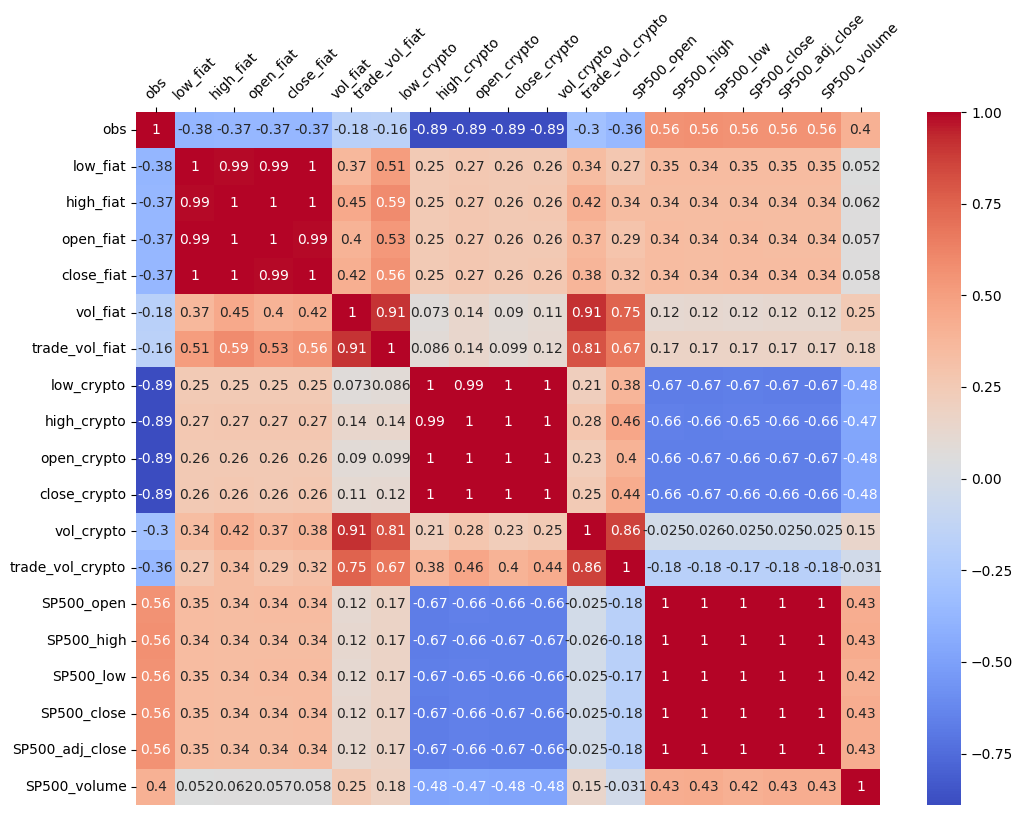

In [893]:
# Plot the heatmap
plt.subplots(figsize=(12, 9))
hm2 = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 10})
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=45)
hm2.xaxis.set_ticks_position('top')

# Create new features

In [894]:
# Feature creation
df['change'] = df['open_fiat'] - df['close_fiat']
df['change'] = df['change'] + abs(df['change'].min())
df['range'] = df['high_fiat'] - df['low_fiat']
df['high_fiat_square'] = (df['high_fiat']) * (df['high_fiat'])
df['low_fiat_square'] = (df['low_fiat']) * (df['low_fiat'])
df

,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,...,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume,change,range,high_fiat_square,low_fiat_square
0,2019-10-01,69.103,72.883,71.188,70.718,3671.094246,2.596124e+05,0.008355,0.008648,0.008566,...,8026.830078,8062.500000,7906.290039,7908.680176,7908.680176,2.250500e+09,97.896,3.780,5311.931689,4775.224609
1,2019-10-02,69.012,70.998,70.691,70.969,1455.866969,1.033214e+05,0.008383,0.008520,0.008447,...,7851.129883,7852.700195,7744.959961,7785.250000,7785.250000,2.503630e+09,97.148,1.986,5040.716004,4762.656144
2,2019-10-03,68.006,71.232,71.109,69.297,2087.604971,1.446648e+05,0.008368,0.008548,0.008444,...,7787.020020,7872.259766,7700.000000,7872.259766,7872.259766,2.157220e+09,99.238,3.226,5073.997824,4624.816036
3,2019-10-04,68.002,70.573,69.328,69.864,1770.263955,1.236777e+05,0.008415,0.008565,0.008452,...,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09,96.890,2.571,4980.548329,4624.272004
4,2019-10-05,68.341,70.350,69.846,70.214,1541.626939,1.082438e+05,0.008500,0.008616,0.008550,...,7908.439941,7986.620117,7899.390137,7982.470215,7982.470215,1.748000e+09,97.058,2.009,4949.122500,4670.492281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2024-02-25,29.720,31.010,30.450,30.940,6987.398035,2.161901e+05,0.000577,0.000602,0.000585,...,16094.799805,16134.219727,15954.500000,15996.820313,15996.820313,5.077910e+09,96.936,1.290,961.620100,883.278400
1609,2024-02-26,29.950,33.090,30.940,31.810,27156.757600,8.638565e+05,0.000576,0.000604,0.000604,...,16014.450195,16054.900391,15973.900391,15976.250000,15976.250000,5.417630e+09,96.556,3.140,1094.948100,897.002500
1610,2024-02-27,31.300,32.930,31.910,32.090,20377.463480,6.539128e+05,0.000560,0.000583,0.000582,...,16013.980469,16046.099609,15940.509766,16035.299805,16035.299805,5.423020e+09,97.246,1.630,1084.384900,979.690000
1611,2024-02-28,28.610,33.030,32.090,31.250,34304.551080,1.072017e+06,0.000477,0.000561,0.000558,...,15969.139648,16003.559570,15924.719727,15947.740234,15947.740234,5.581690e+09,98.266,4.420,1090.980900,818.532100


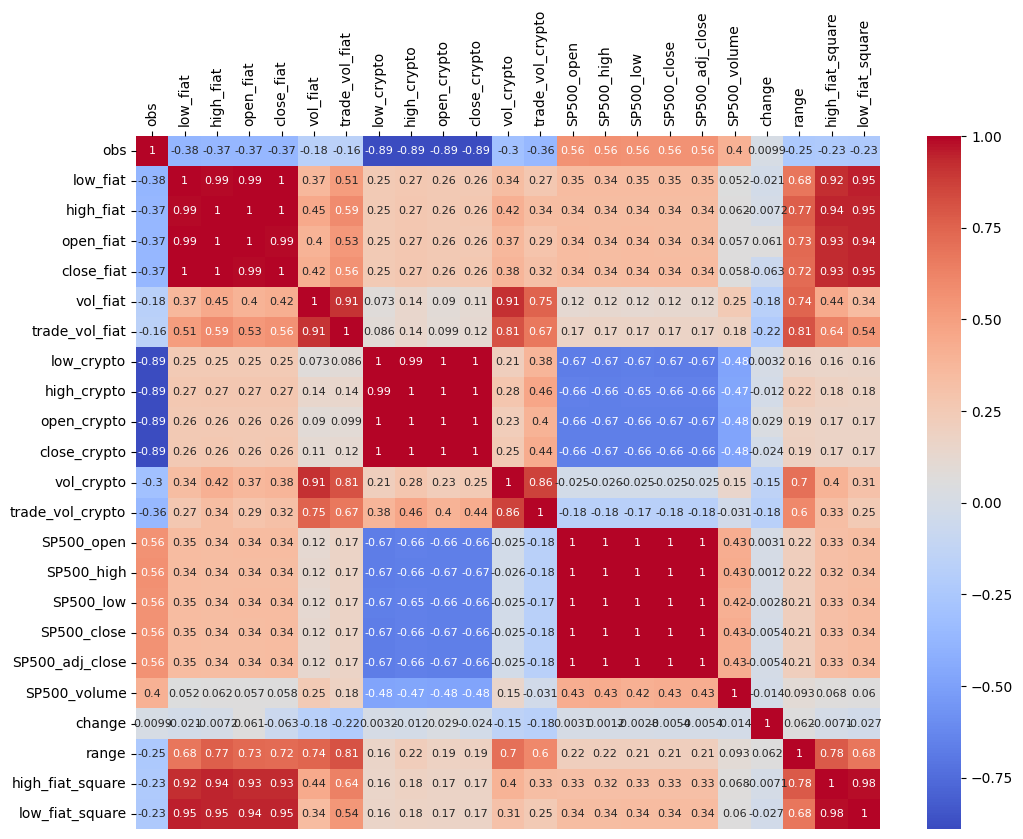

In [895]:
# Plot the heatmap after create new features
plt.subplots(figsize=(12, 9))
hm2 = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8})
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

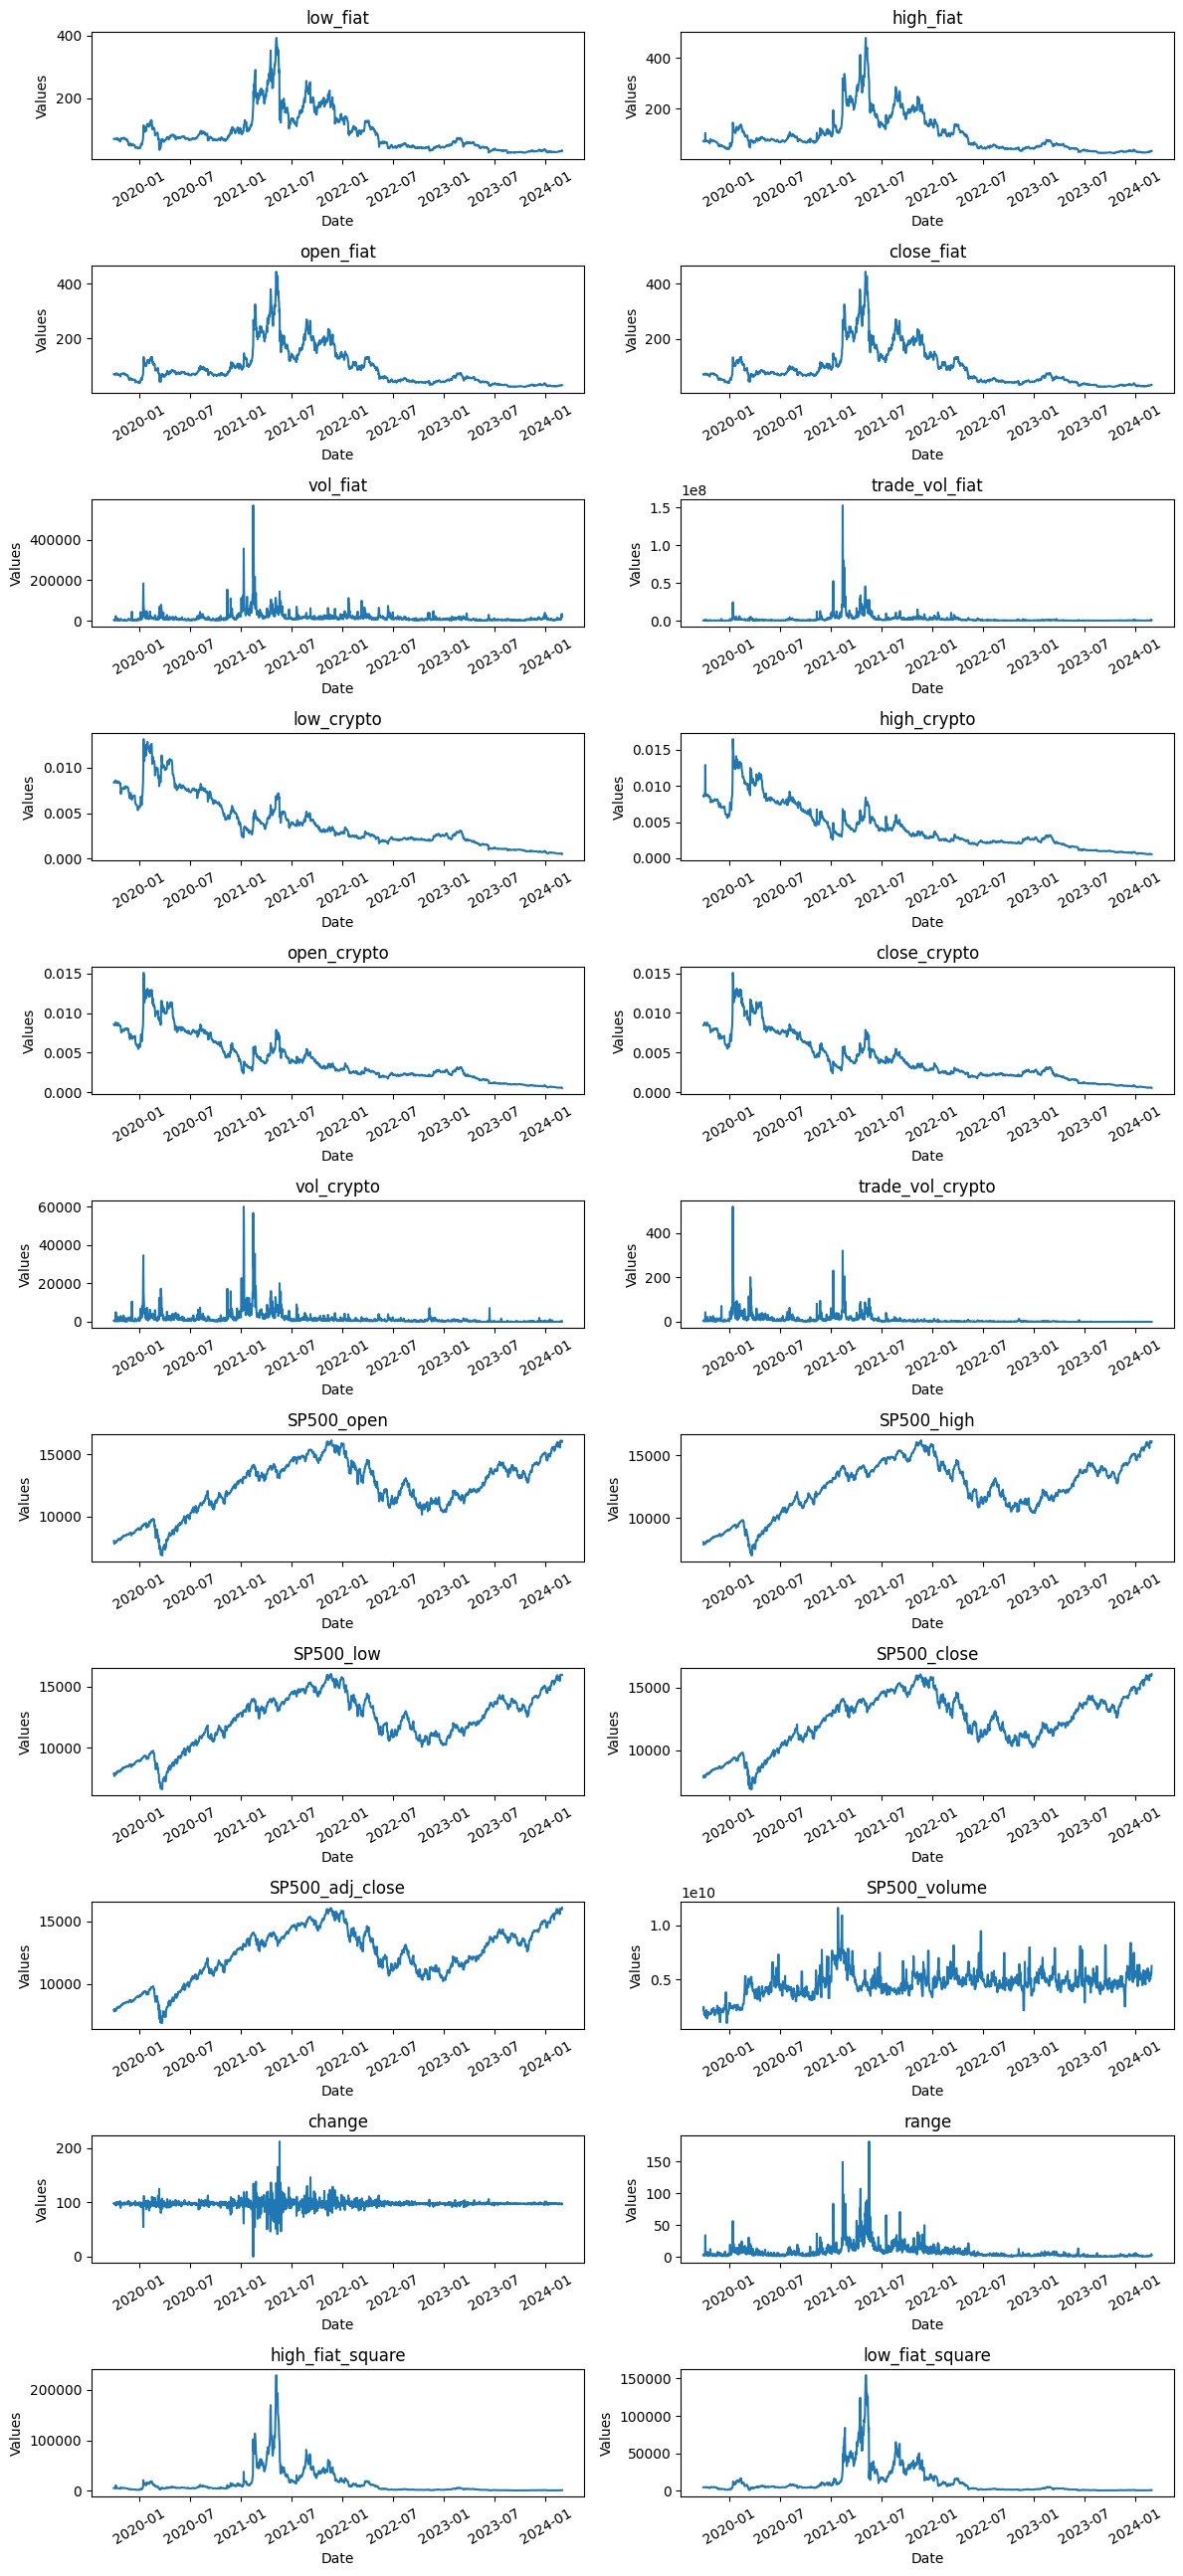

In [896]:
# Plot the graphs of each variable

import matplotlib.pyplot as plt

# Adjust the figure size as needed
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(12, 26))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Plot each column against 'obs' in a subplot
for i, column in enumerate(df.columns[1:]):
    ax = axes[i]
    ax.plot(df['obs'], df[column])
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.tick_params(axis='x', rotation=30, labelsize = 10)
# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()


In [897]:
# Apply log transformation to all data (I find that it can improve the prediction performance)
columns_to_transform = ['SP500_high', 'SP500_volume', 'high_fiat_square', 'low_fiat_square', 'change', 'high_fiat', 'low_fiat', 'vol_fiat', 'trade_vol_fiat', 'low_crypto', 'high_crypto', 'vol_crypto', 'trade_vol_crypto']
columns_to_transform = ['SP500_high', 'SP500_volume', 'high_fiat_square', 'low_fiat_square', 'change', 'high_fiat', 'low_fiat', 'vol_fiat', 'trade_vol_fiat', 'low_crypto', 'high_crypto', 'vol_crypto', 'trade_vol_crypto']
df[columns_to_transform] = df[columns_to_transform].apply(lambda x: np.log(x + 1))
#df[columns_to_transform] = df[columns_to_transform].apply(np.log)
df

,obs,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,...,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume,change,range,high_fiat_square,low_fiat_square
0,2019-10-01,4.249966,4.302483,71.188,70.718,8.208517,12.466949,0.008320,0.008611,0.008566,...,8026.830078,8.995103,7906.290039,7908.680176,7908.680176,21.534418,4.594069,3.780,8.577899,8.471406
1,2019-10-02,4.248667,4.276638,70.691,70.969,7.284043,11.545610,0.008348,0.008484,0.008447,...,7851.129883,8.968740,7744.959961,7785.250000,7785.250000,21.641008,4.586477,1.986,8.525502,8.468771
2,2019-10-03,4.234193,4.279883,71.109,69.297,7.644252,11.882181,0.008333,0.008512,0.008444,...,7787.020020,8.971227,7700.000000,7872.259766,7872.259766,21.492086,4.607547,3.226,8.532081,8.439408
3,2019-10-04,4.234135,4.270718,69.328,69.864,7.479449,11.725443,0.008380,0.008528,0.008452,...,7908.439941,8.985648,7899.390137,7982.470215,7982.470215,21.281738,4.583844,2.571,8.513496,8.439290
4,2019-10-05,4.239036,4.267597,69.846,70.214,7.341242,11.592151,0.008465,0.008579,0.008550,...,7908.439941,8.985648,7899.390137,7982.470215,7982.470215,21.281738,4.585559,2.009,8.507168,8.449234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2024-02-25,3.424914,3.466048,30.450,30.940,8.852007,12.283918,0.000577,0.000602,0.000585,...,16094.799805,9.688760,15954.500000,15996.820313,15996.820313,22.348166,4.584314,1.290,6.869659,6.784772
1609,2024-02-26,3.432373,3.529004,30.940,31.810,10.209418,13.669163,0.000576,0.000604,0.000604,...,16014.450195,9.683832,15973.900391,15976.250000,15976.250000,22.412924,4.580427,3.140,6.999375,6.800173
1610,2024-02-27,3.475067,3.524300,31.910,32.090,9.922234,13.390731,0.000560,0.000583,0.000582,...,16013.980469,9.683283,15940.509766,16035.299805,16035.299805,22.413919,4.587475,1.630,6.989690,6.888256
1611,2024-02-28,3.388112,3.527242,32.090,31.250,10.443062,13.885054,0.000477,0.000561,0.000558,...,15969.139648,9.680629,15924.719727,15947.740234,15947.740234,22.442757,4.597803,4.420,6.995749,6.708734


# Inspect outliers

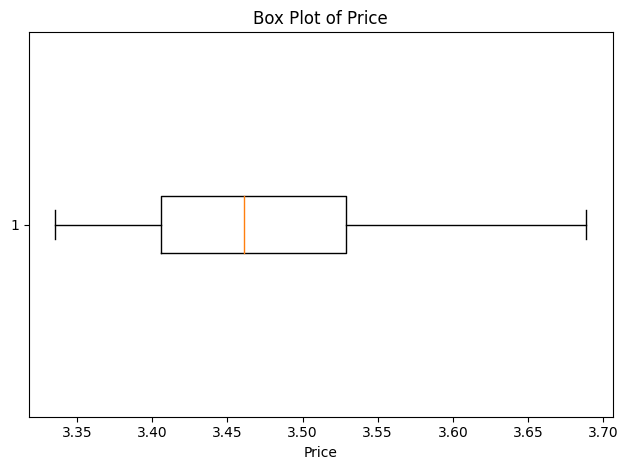

In [898]:
# The box plot of highest price distribution
cut_off_index = 1500
plt.boxplot(x=df[cut_off_index:]['high_fiat'], vert=False)
plt.xlabel('Price')
plt.title('Box Plot of Price')

plt.tight_layout()
plt.show()

In [899]:
# Test the staionality of the time series data
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['high_fiat'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the test results
if result[1] <= 0.05:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is non-stationary")


ADF Statistic: -1.4879696422268103
p-value: 0.539453968809526
Critical Values: {'1%': -3.4344156425955177, '5%': -2.86333574401553, '10%': -2.5677260171554885}
Fail to reject the null hypothesis - Data is non-stationary


# Baseline model: ARIMA with exogneous variables (ARIMAX)
Since ARIMA is a classical time series forecasting model, we use ARIMAX as the baseline model.

# Train Test Split

In [900]:
# Train test split (adjust it may report an error)
training_ratio = 0.92
# Split the whole dataset
used_data = df[cut_off_index:]
used_target_data_high = used_data['high_fiat']
used_target_data_low = used_data['low_fiat']
# For target variable
training_size = int(training_ratio * len(used_target_data_high))
training_set_high = used_target_data_high.iloc[:training_size]
testing_set_high = used_target_data_high.iloc[training_size:]
training_set_low = used_target_data_low.iloc[:training_size]
testing_set_low = used_target_data_low.iloc[training_size:]
# For exgo variables
exgo_features_high = [ 'range', 'change','low_fiat', 'close_fiat', 'vol_fiat', 'trade_vol_fiat', 'vol_crypto', 'low_crypto', 'open_crypto', 'trade_vol_crypto']
exgo_features_low = [ 'range', 'change','high_fiat', 'close_fiat', 'vol_fiat', 'trade_vol_fiat', 'vol_crypto', 'high_crypto', 'open_crypto', 'trade_vol_crypto']
exog_var_train_high = used_data[:training_size][exgo_features_high]
exog_var_test_high = used_data[training_size:][exgo_features_high]
exog_var_train_low = used_data[:training_size][exgo_features_low]
exog_var_test_low = used_data[training_size:][exgo_features_low]
# Check the shape of trsining/testing sets
print(training_set_high.shape[0], testing_set_high.shape[0])
print(training_set_low.shape[0], testing_set_low.shape[0])
testing_set_high


103 10
103 10


1603    3.461351
1604    3.436886
1605    3.464798
1606    3.442979
1607    3.465736
1608    3.466048
1609    3.529004
1610    3.524300
1611    3.527242
1612    3.550766
Name: high_fiat, dtype: float64

In [901]:
# Build the ARIMA model to predict highest price
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# The following 3 lines make sure that the information of the exog variables in the last 10 days will not be used in both training and prediction
# To do this, we move exogneous variables back by 10 units
shifted_exog_var_train_high = exog_var_train_high.iloc[0:-len(exog_var_test_high)]
shifted_exog_var_train_high.index = shifted_exog_var_train_high.index + len(exog_var_test_high)
shifted_training_set_high = training_set_high.iloc[len(exog_var_test_high):]

print(exog_var_train_high.shape, shifted_training_set_high.shape)
print(exog_var_train_high.index, shifted_training_set_high.index)
model_high = sm.tsa.ARIMA(shifted_training_set_high, exog = shifted_exog_var_train_high, order=(2, 1, 0))
model_high_fit = model_high.fit()

# Predict the price of len(testing_set) days using the fitted model
predictions_high = model_high_fit.forecast(steps=len(testing_set_high), exog = exog_var_train_high.iloc[-len(exog_var_test_high):])

# Calculate Training Mean Absolute Error (MAE)
mae_high_train_ARIMA = mean_absolute_error(shifted_training_set_high, model_high_fit.fittedvalues)
print('Training Mean Absolute Error:', mae_high_train_ARIMA)

# Calculate Testing Mean Absolute Error (MAE)
mae_high_test_ARIMA = mean_absolute_error(testing_set_high, predictions_high)
print('Testing Mean Absolute Error: ', mae_high_test_ARIMA)

# Calculate R^2 score training
r2_high_train_ARIMA = r2_score(shifted_training_set_high, model_high_fit.fittedvalues)
print('Training R^2 Score:', r2_high_train_ARIMA)

# Calculate R^2 score testing
r2_high_test_ARIMA = r2_score(testing_set_high, predictions_high)
print('Testing R^2 Score: ', r2_high_test_ARIMA)



(103, 10) (93,)
RangeIndex(start=1500, stop=1603, step=1) RangeIndex(start=1510, stop=1603, step=1)
Training Mean Absolute Error: 0.061829295222406336
Testing Mean Absolute Error:  0.04007542551502659
Training R^2 Score: -20.666047670872455
Testing R^2 Score:  -0.8778708021949517


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [902]:
# Build the ARIMA model to predict lowest price
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

shifted_exog_var_train_low = exog_var_train_low.iloc[0:-len(exog_var_test_high)]
shifted_exog_var_train_low.index = shifted_exog_var_train_low.index + len(exog_var_test_high)

shifted_training_set_low = training_set_low.iloc[len(exog_var_test_high):]
print(exog_var_train_low.shape, shifted_training_set_low.shape)
print(exog_var_train_low.index, shifted_training_set_low.index)
model_low = sm.tsa.ARIMA(shifted_training_set_low, exog = shifted_exog_var_train_low, order=(2, 1, 0))
model_low_fit = model_low.fit()


# Predict the price of len(testing_set) days using the fitted model
predictions_low = model_low_fit.forecast(steps=len(testing_set_low), exog = exog_var_train_low.iloc[-len(exog_var_test_low):])



# Calculate Training Mean Absolute Error (MAE)
mae_low_train_ARIMA = mean_absolute_error(shifted_training_set_low, model_low_fit.fittedvalues)
print('Training Mean Absolute Error:', mae_low_train_ARIMA)

# Calculate Testing Mean Absolute Error (MAE)
mae_low_test_ARIMA = mean_absolute_error(testing_set_low, predictions_low)
print('Testing Mean Absolute Error: ', mae_low_test_ARIMA)

# Calculate R^2 score training
r2_low_train_ARIMA = r2_score(shifted_training_set_low, model_low_fit.fittedvalues)
print('Training R^2 Score:', r2_low_train_ARIMA)

# Calculate R^2 score testing
r2_low_test_ARIMA = r2_score(testing_set_low, predictions_low)
print('Testing R^2 Score: ', r2_low_test_ARIMA)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(103, 10) (93,)
RangeIndex(start=1500, stop=1603, step=1) RangeIndex(start=1510, stop=1603, step=1)
Training Mean Absolute Error: 0.046122372170513556
Testing Mean Absolute Error:  0.02948224819637928
Training R^2 Score: -5.74677759869348
Testing R^2 Score:  -0.15826094062724883


In [903]:
# Get the fitted values
fitted_high = model_high_fit.fittedvalues
fitted_low = model_low_fit.fittedvalues
fitted_high

1510   -0.437171
1511    3.475187
1512    3.466042
1513    3.465844
1514    3.411121
          ...   
1598    3.399541
1599    3.424532
1600    3.414720
1601    3.449894
1602    3.464900
Length: 93, dtype: float64

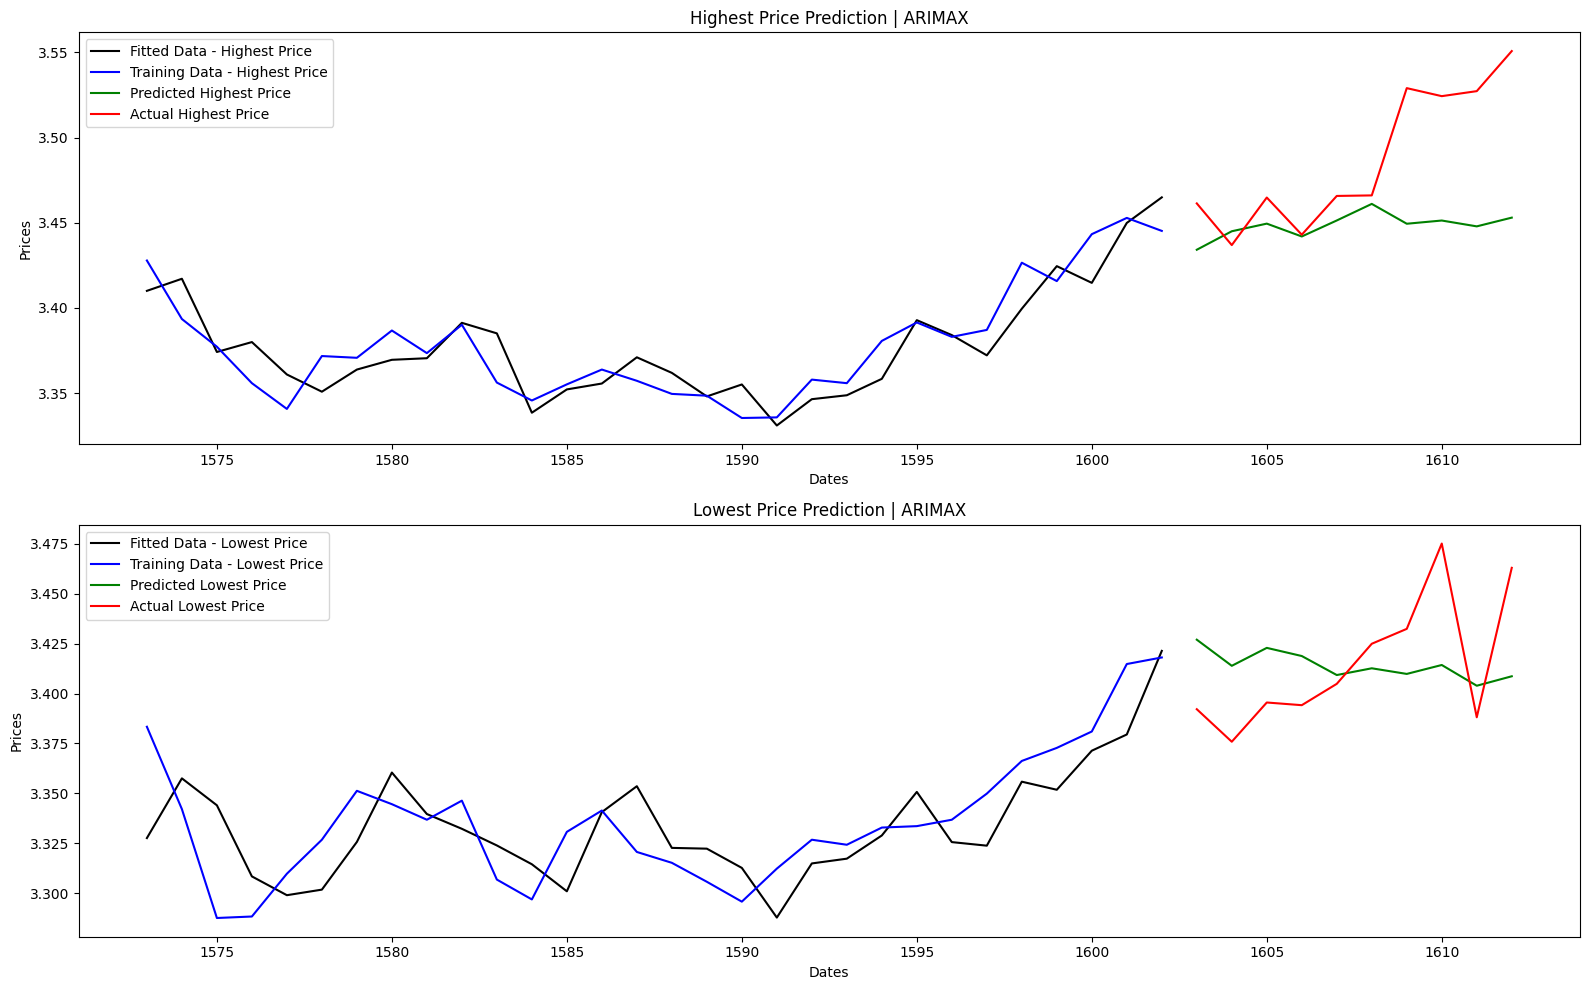

In [904]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Plot highest price subplot
plt.subplot(2, 1, 1)
plt.plot(fitted_high[-30:], color='black', label='Fitted Data - Highest Price')
plt.plot(training_set_high[-30:], color='blue', label='Training Data - Highest Price')
plt.plot(testing_set_high.index, predictions_high, color='green', label='Predicted Highest Price')
plt.plot(testing_set_high.index, testing_set_high, color='red', label='Actual Highest Price')
plt.title('Highest Price Prediction | ARIMAX')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Plot lowest price subplot
plt.subplot(2, 1, 2)
plt.plot(fitted_low[-30:], color='black', label='Fitted Data - Lowest Price')
plt.plot(training_set_low[-30:], color='blue', label='Training Data - Lowest Price')
plt.plot(testing_set_low.index, predictions_low, color='green', label='Predicted Lowest Price')
plt.plot(testing_set_low.index, testing_set_low, color='red', label='Actual Lowest Price')
plt.title('Lowest Price Prediction | ARIMAX')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

plt.tight_layout()
plt.show()


# XGBoost model

In [905]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

# setting used data
test_size = 10
cut_off_index_xgb_high = 600
cut_off_index_xgb_low = 1000
used_features_high = df.columns[1:-2]
used_features_low = df.columns[1:-2]

used_data_xgb_high = df[cut_off_index_xgb_high:][used_features_high]
used_data_xgb_low = df[cut_off_index_xgb_low:][used_features_low]
# train test split
# high
X_train_high = used_data_xgb_high[0 :-2*test_size]#['high_fiat']
Y_train_high = used_data_xgb_high[test_size: -test_size]['high_fiat']
X_test_high = used_data_xgb_high[test_size :-test_size]#['high_fiat']
Y_test_high = used_data_xgb_high[-test_size:]['high_fiat']

# low
X_train_low = used_data_xgb_low[0 :-2*test_size]#['low_fiat']
Y_train_low = used_data_xgb_low[test_size: -test_size]['low_fiat']
X_test_low = used_data_xgb_low[test_size :-test_size]#['low_fiat']
Y_test_low = used_data_xgb_low[-test_size:]['low_fiat']

In [906]:
# These hyperparameters are turned by GridSearchCV (I only keep the optimal values for the CV to shorten the run duration)
parameters_high = {
    'n_estimators': [50],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.005],
    'random_state': [42],
    'min_child_weight':[2],
    'subsample':[0.6],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
kfold=KFold(5)
eval_set = [(X_train_high, Y_train_high), (X_test_high, Y_test_high)]
model_xgb_high = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf_high = GridSearchCV(model_xgb_high, parameters_high,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

clf_high.fit(X_train_high, Y_train_high)

print(f'Best params: {clf_high.best_params_}')
print(f'Best validation score = {clf_high.best_score_}')

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.6}
Best validation score = -0.25855319681740435


In [907]:
# These hyperparameters are turned by GridSearchCV and hands
parameters_low = {
    'n_estimators': [50],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.005],
    'random_state': [42],
    'min_child_weight':[2],
    'subsample':[0.6],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
kfold=KFold(5)
eval_set = [(X_train_low, Y_train_low), (X_test_low, Y_test_low)]
model_xgb_low = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf_low = GridSearchCV(model_xgb_low, parameters_low,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

clf_low.fit(X_train_low, Y_train_low)

print(f'Best params: {clf_low.best_params_}')
print(f'Best validation score = {clf_low.best_score_}')



Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.6}
Best validation score = -0.11886893027577972


In [908]:

model_xgb_high = XGBRegressor(**clf_high.best_params_, objective='reg:squarederror',n_jobs=-1)
model_xgb_high.fit(X_train_high, Y_train_high)
Y_pred_high = model_xgb_high.predict(X_test_high[-test_size:])
mae_high_test_xgb = mean_absolute_error(Y_test_high, Y_pred_high)
fitted_val_high = model_xgb_high.predict(X_train_high)

fitted_val_high = pd.Series(fitted_val_high, index = Y_train_high.index)

In [909]:
# Build the model
model_xgb_low = XGBRegressor(**clf_low.best_params_, objective='reg:squarederror',n_jobs=-1)
model_xgb_low.fit(X_train_low, Y_train_low)
Y_pred_low = model_xgb_low.predict(X_test_low[-test_size:])
mae_low_test_xgb = mean_absolute_error(Y_test_low, Y_pred_low)
fitted_val_low = model_xgb_low.predict(X_train_low)

fitted_val_low = pd.Series(fitted_val_low, index = Y_train_low.index)

In [910]:
# Calculate Training Mean Absolute Error (MAE)
mae_high_train_XGB = mean_absolute_error(X_train_high['high_fiat'], fitted_val_high)
print('Training Mean Absolute Error:', mae_high_train_XGB)

# Calculate Testing Mean Absolute Error (MAE)
mae_high_test_XGB = mean_absolute_error(Y_test_high, Y_pred_high)
print('Testing Mean Absolute Error: ', mae_high_test_XGB)

Training Mean Absolute Error: 0.09089910852446638
Testing Mean Absolute Error:  0.021846798055235307


In [911]:
# Calculate Training Mean Absolute Error (MAE)
mae_low_train_XGB = mean_absolute_error(X_train_low['low_fiat'], fitted_val_low)
print('Training Mean Absolute Error:', mae_low_train_XGB)

# Calculate Testing Mean Absolute Error (MAE)
mae_low_test_XGB = mean_absolute_error(Y_test_low, Y_pred_low)
print('Testing Mean Absolute Error: ', mae_low_test_XGB)



Training Mean Absolute Error: 0.06672503134296333
Testing Mean Absolute Error:  0.01955504737207363


In [912]:
Y_pred_high = pd.Series(Y_pred_high, index = Y_test_high.index)
Y_pred_low = pd.Series(Y_pred_low, index = Y_test_low.index)

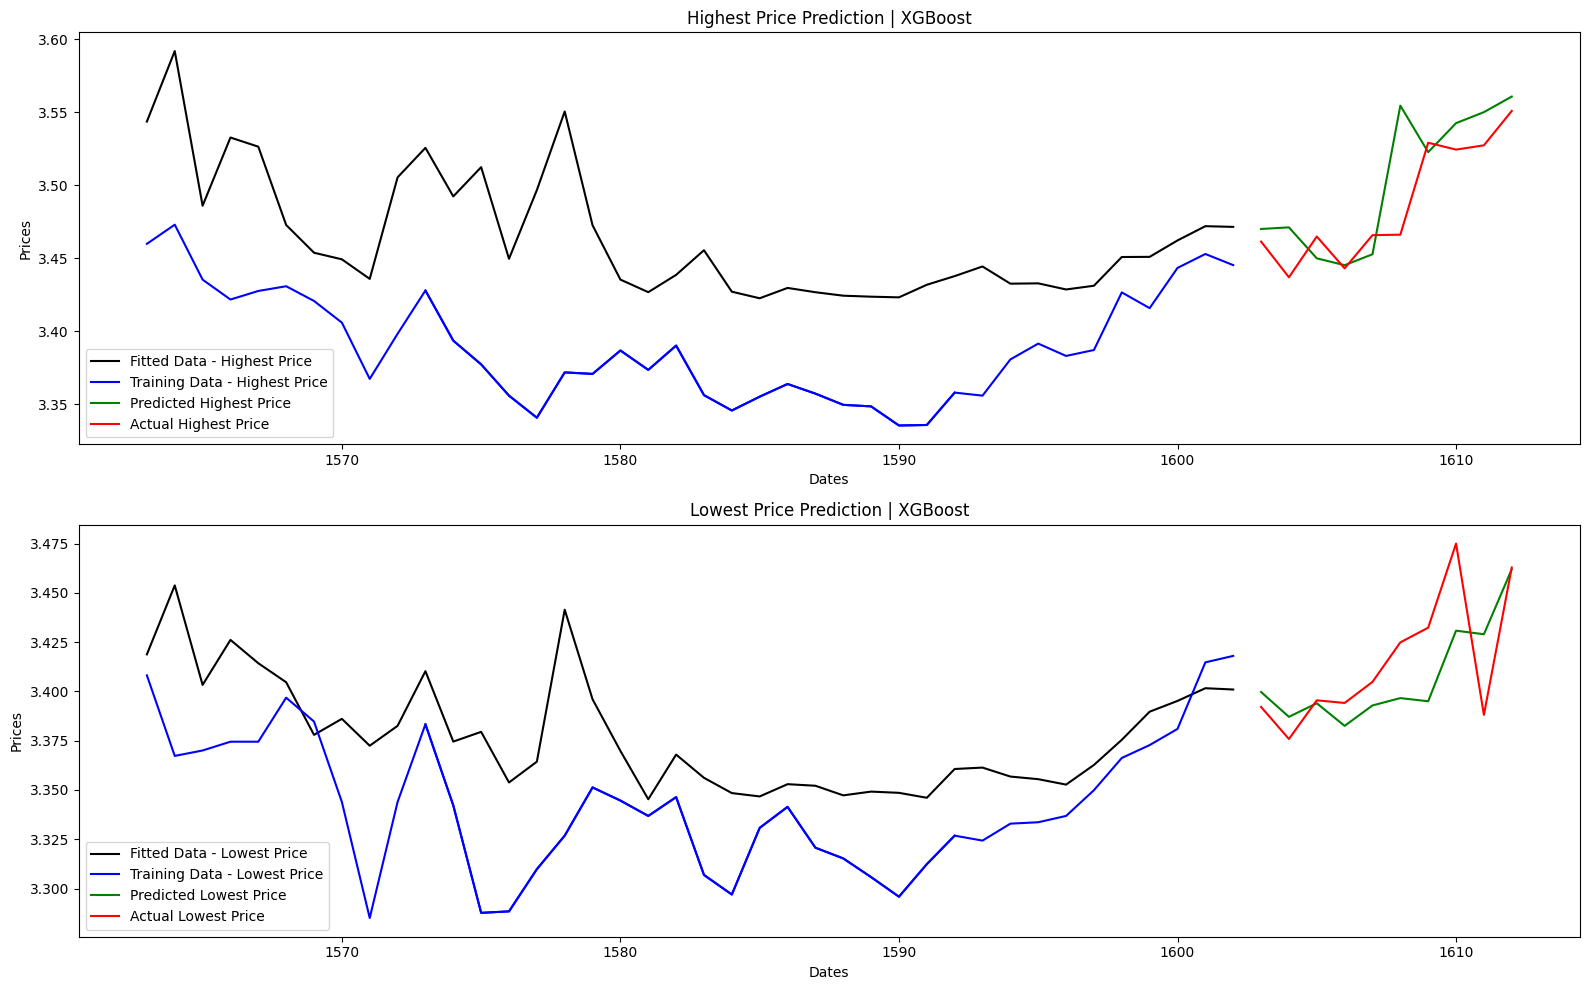

In [913]:
plt.figure(figsize=(16, 10))

# Plot highest price subplot
plt.subplot(2, 1, 1)
plt.plot(fitted_val_high[-40:], color='black', label='Fitted Data - Highest Price')
plt.plot(X_train_high['high_fiat'][-30:], color='blue', label='Training Data - Highest Price')
plt.plot(Y_train_high[-30:], color='blue')
plt.plot(Y_pred_high, color='green', label='Predicted Highest Price')
plt.plot(Y_test_high, color='red', label='Actual Highest Price')
plt.title('Highest Price Prediction | XGBoost')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Plot lowest price subplot
plt.subplot(2, 1, 2)
plt.plot(fitted_val_low[-40:], color='black', label='Fitted Data - Lowest Price')
plt.plot(X_train_low['low_fiat'][-30:], color='blue', label='Training Data - Lowest Price')
plt.plot(Y_train_low[-30:], color='blue')
plt.plot(Y_pred_low, color='green', label='Predicted Lowest Price')
plt.plot(Y_test_low, color='red', label='Actual Lowest Price')
plt.title('Lowest Price Prediction | XGBoost')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()



plt.tight_layout()
plt.show()

# LSTM model

# Train Test Split

In [914]:
# Use data after this index to avoid overfitting
cut_off_index_lstm = 1000


# setting used data
used_data_lstm_high = df[cut_off_index_lstm:][used_features_high]
used_data_lstm_low = df[cut_off_index_lstm:][used_features_low]

X_high = used_data_lstm_high[0:-test_size]
Y_high = used_data_lstm_high['high_fiat'][-test_size:]
X_low = used_data_lstm_low[0:-test_size]
Y_low = used_data_lstm_low['low_fiat'][-test_size:]
# high
train_high = used_data_lstm_high[0: -test_size]
test_high = used_data_lstm_high

# low
train_low = used_data_lstm_low[0: -test_size]
test_low = used_data_lstm_low

train_high

,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume,change,range
1000,3.901771,3.963666,49.30,49.13,9.039505,12.933859,0.002337,0.002403,0.002341,0.002375,6.820516,1.155059,11661.019531,9.365504,11487.070313,11524.549805,11524.549805,22.342230,4.591031,3.16
1001,3.845883,3.927503,49.06,46.22,9.013232,12.846525,0.002260,0.002389,0.002373,0.002287,7.368232,1.530875,11542.240234,9.361932,11177.679688,11181.540039,11181.540039,22.415798,4.617751,3.98
1002,3.804883,3.869950,46.23,44.58,9.761533,13.558762,0.002201,0.002306,0.002283,0.002231,7.298353,1.457424,11160.219727,9.326106,11072.190430,11177.889648,11177.889648,22.455074,4.605930,3.02
1003,3.718681,3.826029,44.56,42.03,10.645554,14.383914,0.002112,0.002228,0.002220,0.002145,7.777627,1.811091,11048.250000,9.320263,10850.009766,11028.740234,11028.740234,22.455721,4.614685,4.67
1004,3.730501,3.793690,42.09,41.70,9.633412,13.363849,0.002078,0.002208,0.002144,0.002160,6.919798,1.158141,11006.830078,9.317718,10922.709961,11127.849609,11127.849609,22.305483,4.593260,2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,3.366261,3.426540,28.19,29.07,9.369915,12.739539,0.000543,0.000561,0.000545,0.000561,4.048510,0.031102,15865.299805,9.674843,15779.719727,15906.169922,15906.169922,22.523175,4.580324,1.80
1599,3.372798,3.415758,28.98,29.06,9.177668,12.546931,0.000550,0.000561,0.000561,0.000557,4.329720,0.040885,15910.429688,9.675232,15752.019531,15775.650391,15775.650391,22.376491,4.588492,1.28
1600,3.380995,3.443299,29.07,30.26,8.912073,12.321770,0.000555,0.000587,0.000558,0.000587,4.847589,0.071591,15910.429688,9.675232,15752.019531,15775.650391,15775.650391,22.376491,4.577141,1.89
1601,3.414772,3.452841,30.28,29.78,8.938823,12.332533,0.000571,0.000592,0.000585,0.000571,3.584381,0.019805,15910.429688,9.675232,15752.019531,15775.650391,15775.650391,22.376491,4.594372,1.18


In [915]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))

# high
train_high_scaled= ss.fit_transform(train_high)
ytrain_high_scaled= ss.fit_transform(train_high['high_fiat'].values.reshape(-1,1))
test_high_scaled = ss.fit_transform(test_high)
#ytest_high_scaled = ss.fit_transform(Y_test_high.values)

# low
train_low_scaled= ss.fit_transform(train_low)
ytrain_low_scaled= ss.fit_transform(train_low['low_fiat'].values.reshape(-1,1))
test_low_scaled = ss.fit_transform(test_low)
#ytest_low_scaled = ss.fit_transform(Y_test_low.values)


In [916]:
number_of_features = used_data_lstm_high.shape[1]

The data leakage is very crucial in time series forecasting. For example, if we simply cut the dataset into train and test set and then directly use the test set to forecast the future price, the model performance may be excellent because the thing we do is actually use future price to pridict future price. Therefore, to avoid it, the test set below do not include the price and other time series data of the last 10 days, since they should be predicted and then compare with real data.

In [917]:
# Feature selection
# high
xtrain_high=[]
ytrain_high=[]
for i in range(20,len(train_high_scaled)):
    xtrain_high.append(train_high_scaled[range(i-20, i-10)])
    ytrain_high.append(ytrain_high_scaled[range(i-10, i)])
xtrain_high, ytrain_high = np.array(xtrain_high), np.array(ytrain_high)
#xtrain_high=np.reshape(xtrain_high,(xtrain_high.shape[0],xtrain_high.shape[1],number_of_features))

# low
xtrain_low=[]
ytrain_low=[]
for i in range(20,len(train_low_scaled)):
    xtrain_low.append(train_low_scaled[range(i-20, i-10)])
    ytrain_low.append(ytrain_low_scaled[range(i-10, i)])
xtrain_low, ytrain_low = np.array(xtrain_low), np.array(ytrain_low)
#xtrain=np.reshape(xtrain_low,(xtrain_low.shape[0],xtrain_low.shape[1],number_of_features))



xtrain_high.shape

(583, 10, 20)

In [918]:
test_high

,low_fiat,high_fiat,open_fiat,close_fiat,vol_fiat,trade_vol_fiat,low_crypto,high_crypto,open_crypto,close_crypto,vol_crypto,trade_vol_crypto,SP500_open,SP500_high,SP500_low,SP500_close,SP500_adj_close,SP500_volume,change,range
1000,3.901771,3.963666,49.30,49.13,9.039505,12.933859,0.002337,0.002403,0.002341,0.002375,6.820516,1.155059,11661.019531,9.365504,11487.070313,11524.549805,11524.549805,22.342230,4.591031,3.16
1001,3.845883,3.927503,49.06,46.22,9.013232,12.846525,0.002260,0.002389,0.002373,0.002287,7.368232,1.530875,11542.240234,9.361932,11177.679688,11181.540039,11181.540039,22.415798,4.617751,3.98
1002,3.804883,3.869950,46.23,44.58,9.761533,13.558762,0.002201,0.002306,0.002283,0.002231,7.298353,1.457424,11160.219727,9.326106,11072.190430,11177.889648,11177.889648,22.455074,4.605930,3.02
1003,3.718681,3.826029,44.56,42.03,10.645554,14.383914,0.002112,0.002228,0.002220,0.002145,7.777627,1.811091,11048.250000,9.320263,10850.009766,11028.740234,11028.740234,22.455721,4.614685,4.67
1004,3.730501,3.793690,42.09,41.70,9.633412,13.363849,0.002078,0.002208,0.002144,0.002160,6.919798,1.158141,11006.830078,9.317718,10922.709961,11127.849609,11127.849609,22.305483,4.593260,2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,3.424914,3.466048,30.45,30.94,8.852007,12.283918,0.000577,0.000602,0.000585,0.000602,3.913943,0.029127,16094.799805,9.688760,15954.500000,15996.820313,15996.820313,22.348166,4.584314,1.29
1609,3.432373,3.529004,30.94,31.81,10.209418,13.669163,0.000576,0.000604,0.000604,0.000582,5.515090,0.134526,16014.450195,9.683832,15973.900391,15976.250000,15976.250000,22.412924,4.580427,3.14
1610,3.475067,3.524300,31.91,32.09,9.922234,13.390731,0.000560,0.000583,0.000582,0.000565,5.215855,0.098478,16013.980469,9.683283,15940.509766,16035.299805,16035.299805,22.413919,4.587475,1.63
1611,3.388112,3.527242,32.09,31.25,10.443062,13.885054,0.000477,0.000561,0.000558,0.000511,6.213064,0.226813,15969.139648,9.680629,15924.719727,15947.740234,15947.740234,22.442757,4.597803,4.42


In [919]:
# Prepare the testing sets
xtest_high= []
for i in range(1612-cut_off_index_lstm-20,1612-cut_off_index_lstm-10):
    xtest_high.append(train_high_scaled[range(i-10, i)])
xtest_high = np.array(xtest_high)

xtest_low= []
for i in range(1612-cut_off_index_lstm-20,1612-cut_off_index_lstm-10):
    xtest_low.append(train_low_scaled[range(i-10, i)])
xtest_low = np.array(xtest_low)


xtest_high.shape

(10, 10, 20)

In [920]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,LSTM, GRU, Bidirectional, Layer, Input, Activation, concatenate
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [921]:
# LSTM model for highest price prediction
model_high_lstm=Sequential()

model_high_lstm.add((LSTM(100, return_sequences=False,input_shape=(xtrain_high.shape[1],number_of_features))))
model_high_lstm.add(Dense(units = 1))

In [922]:
# LSTM model for lowest price prediction
model_low_lstm=Sequential()

model_low_lstm.add((LSTM(50, return_sequences=False,input_shape=(xtrain_high.shape[1],number_of_features))))

model_low_lstm.add(Dense(units = 1))



In [923]:
model_high_lstm.compile(optimizer="adam",loss="mean_absolute_error")
model_low_lstm.compile(optimizer="adam",loss="mean_absolute_error")

In [924]:
model_high_lstm.fit(xtrain_high,ytrain_high,batch_size=36,epochs=20, verbose=2)

Epoch 1/20


17/17 - 1s - loss: 0.1096 - 1s/epoch - 69ms/step
Epoch 2/20
17/17 - 0s - loss: 0.0638 - 97ms/epoch - 6ms/step
Epoch 3/20
17/17 - 0s - loss: 0.0561 - 107ms/epoch - 6ms/step
Epoch 4/20
17/17 - 0s - loss: 0.0571 - 76ms/epoch - 4ms/step
Epoch 5/20
17/17 - 0s - loss: 0.0565 - 83ms/epoch - 5ms/step
Epoch 6/20
17/17 - 0s - loss: 0.0573 - 77ms/epoch - 5ms/step
Epoch 7/20
17/17 - 0s - loss: 0.0538 - 74ms/epoch - 4ms/step
Epoch 8/20
17/17 - 0s - loss: 0.0516 - 72ms/epoch - 4ms/step
Epoch 9/20
17/17 - 0s - loss: 0.0527 - 73ms/epoch - 4ms/step
Epoch 10/20
17/17 - 0s - loss: 0.0523 - 73ms/epoch - 4ms/step
Epoch 11/20
17/17 - 0s - loss: 0.0507 - 74ms/epoch - 4ms/step
Epoch 12/20
17/17 - 0s - loss: 0.0522 - 75ms/epoch - 4ms/step
Epoch 13/20
17/17 - 0s - loss: 0.0542 - 74ms/epoch - 4ms/step
Epoch 14/20
17/17 - 0s - loss: 0.0495 - 77ms/epoch - 5ms/step
Epoch 15/20
17/17 - 0s - loss: 0.0487 - 73ms/epoch - 4ms/step
Epoch 16/20
17/17 - 0s - loss: 0.0500 - 74ms/epoch - 4ms/step
Epoch 17/20
17/17 - 0s - los

In [925]:
model_low_lstm.fit(xtrain_low,ytrain_low,batch_size=36,epochs=20, verbose=2)

Epoch 1/20


17/17 - 1s - loss: 0.1306 - 1s/epoch - 64ms/step
Epoch 2/20
17/17 - 0s - loss: 0.0720 - 46ms/epoch - 3ms/step
Epoch 3/20
17/17 - 0s - loss: 0.0632 - 46ms/epoch - 3ms/step
Epoch 4/20
17/17 - 0s - loss: 0.0585 - 48ms/epoch - 3ms/step
Epoch 5/20
17/17 - 0s - loss: 0.0555 - 45ms/epoch - 3ms/step
Epoch 6/20
17/17 - 0s - loss: 0.0540 - 44ms/epoch - 3ms/step
Epoch 7/20
17/17 - 0s - loss: 0.0537 - 43ms/epoch - 3ms/step
Epoch 8/20
17/17 - 0s - loss: 0.0546 - 43ms/epoch - 3ms/step
Epoch 9/20
17/17 - 0s - loss: 0.0522 - 44ms/epoch - 3ms/step
Epoch 10/20
17/17 - 0s - loss: 0.0530 - 44ms/epoch - 3ms/step
Epoch 11/20
17/17 - 0s - loss: 0.0549 - 43ms/epoch - 3ms/step
Epoch 12/20
17/17 - 0s - loss: 0.0518 - 43ms/epoch - 3ms/step
Epoch 13/20
17/17 - 0s - loss: 0.0515 - 44ms/epoch - 3ms/step
Epoch 14/20
17/17 - 0s - loss: 0.0512 - 44ms/epoch - 3ms/step
Epoch 15/20
17/17 - 0s - loss: 0.0507 - 45ms/epoch - 3ms/step
Epoch 16/20
17/17 - 0s - loss: 0.0503 - 45ms/epoch - 3ms/step
Epoch 17/20
17/17 - 0s - loss

In [926]:
# Predict the highest value
predicted_value_high_lstm= model_high_lstm.predict(xtest_high)
fitted_value_high_lstm = model_high_lstm.predict(xtrain_high)
predicted_value_high_lstm = pd.DataFrame(predicted_value_high_lstm)
predicted_value_high_lstm.index = predicted_value_high_lstm.index + 1603
fitted_value_high_lstm = pd.DataFrame(fitted_value_high_lstm)
fitted_value_high_lstm.index = fitted_value_high_lstm.index + cut_off_index_lstm + 10



# Predict the lowest value
predicted_value_low_lstm= model_low_lstm.predict(xtest_low)
fitted_value_low_lstm = model_low_lstm.predict(xtrain_low)
predicted_value_low_lstm = pd.DataFrame(predicted_value_low_lstm)
predicted_value_low_lstm.index = predicted_value_low_lstm.index + 1603
fitted_value_low_lstm = pd.DataFrame(fitted_value_low_lstm)
fitted_value_low_lstm.index = fitted_value_low_lstm.index + cut_off_index_lstm + 10
fitted_value_low_lstm

19/19 [==============================] - 0s 1ms/step


,0
1010,0.545989
1011,0.573158
1012,0.564353
1013,0.583723
1014,0.542853
...,...
1588,0.119210
1589,0.124883
1590,0.113063
1591,0.122152


In [927]:
fitted_value_high_lstm

,0
1010,0.547020
1011,0.574416
1012,0.570807
1013,0.588820
1014,0.557578
...,...
1588,0.040518
1589,0.046374
1590,0.041029
1591,0.047861


In [928]:
train_high = pd.DataFrame(train_high)
fitted_value_high_lstm = pd.DataFrame(fitted_value_high_lstm)

train_low = pd.DataFrame(train_low)
fitted_value_low_lstm = pd.DataFrame(fitted_value_low_lstm)

In [929]:
# Inverse the scaling
predicted_value_high_lstm = train_high['high_fiat'].min() + predicted_value_high_lstm * (train_high['high_fiat'].max() - train_high['high_fiat'].min())
fitted_value_high_lstm = train_high['high_fiat'].min() + fitted_value_high_lstm * (train_high['high_fiat'].max() - train_high['high_fiat'].min())


# Inverse the scaling
predicted_value_low_lstm = train_low['low_fiat'].min() + predicted_value_low_lstm * (train_low['low_fiat'].max() - train_low['low_fiat'].min())
fitted_value_low_lstm = train_low['low_fiat'].min() + fitted_value_low_lstm * (train_low['low_fiat'].max() - train_low['low_fiat'].min())




In [930]:
training_set_high

1500    3.517795
1501    3.506158
1502    3.538057
1503    3.555062
1504    3.572907
          ...   
1598    3.426540
1599    3.415758
1600    3.443299
1601    3.452841
1602    3.445214
Name: high_fiat, Length: 103, dtype: float64

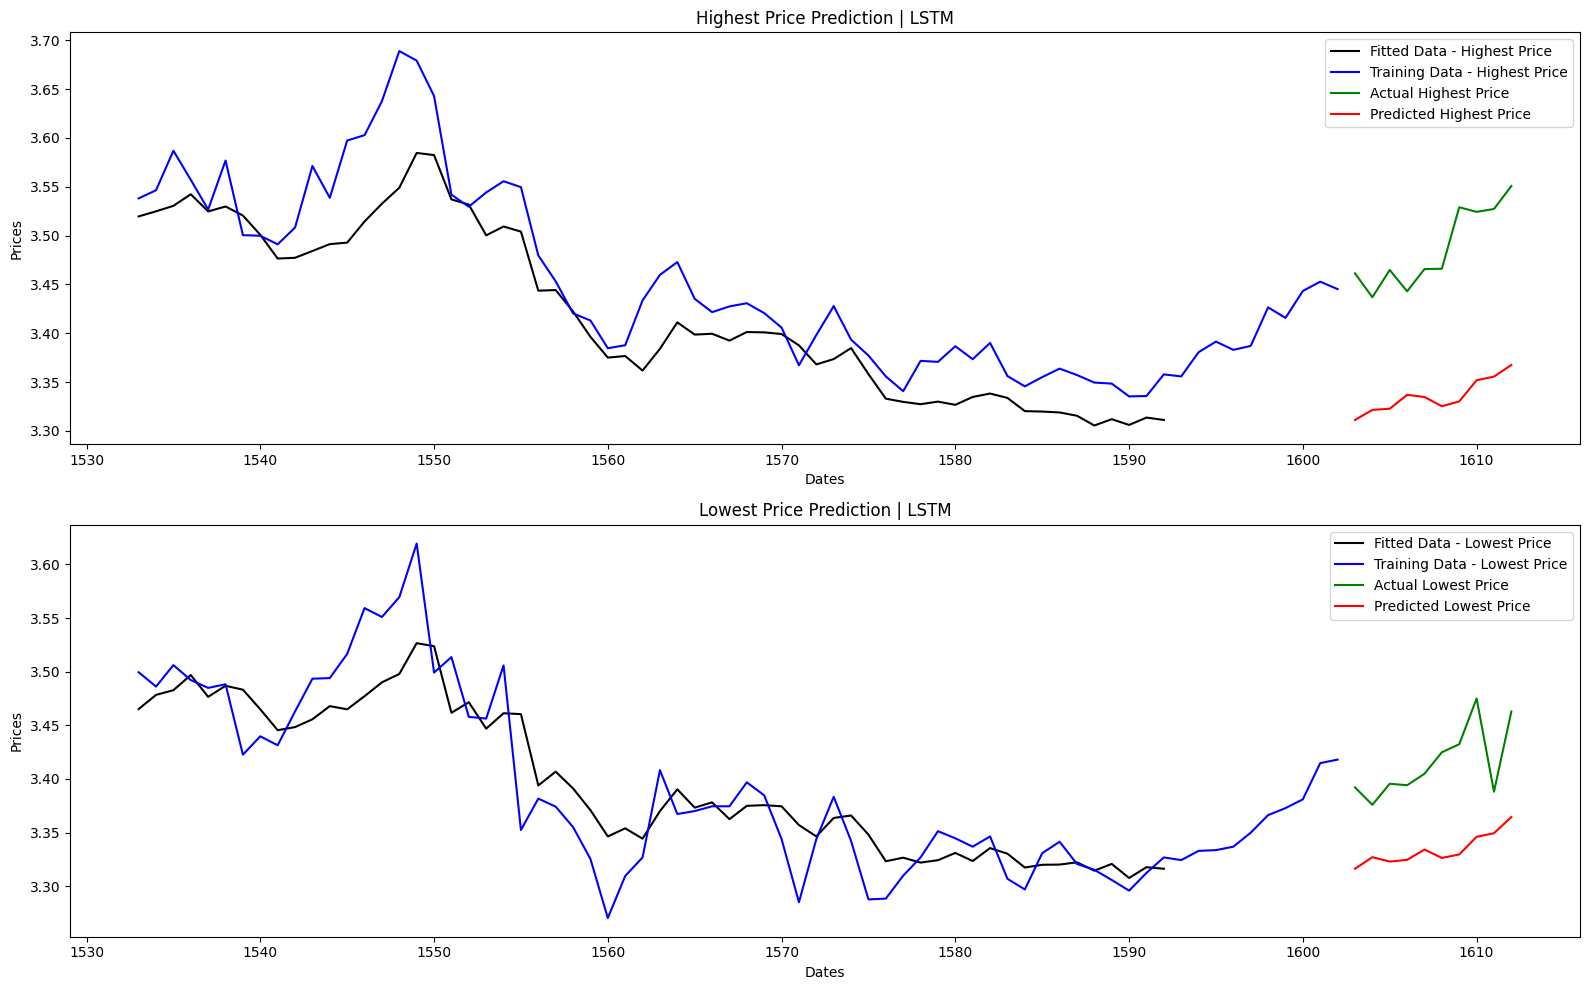

In [931]:
plt.figure(figsize=(16, 10))

# Plot highest price subplot
plt.subplot(2, 1, 1)
plt.plot(fitted_value_high_lstm[-60:], color='black', label='Fitted Data - Highest Price')
plt.plot(training_set_high[-70:], color='blue', label='Training Data - Highest Price')
plt.plot(testing_set_high, color='green', label='Actual Highest Price')
plt.plot(predicted_value_high_lstm, color='red', label='Predicted Highest Price')
plt.title('Highest Price Prediction | LSTM')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Plot lowest price subplot
plt.subplot(2, 1, 2)
plt.plot(fitted_value_low_lstm[-60:], color='black', label='Fitted Data - Lowest Price')
plt.plot(training_set_low[-70:], color='blue', label='Training Data - Lowest Price')
plt.plot(testing_set_low, color='green', label='Actual Lowest Price')
plt.plot(predicted_value_low_lstm, color='red', label='Predicted Lowest Price')
plt.title('Lowest Price Prediction | LSTM')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()




plt.tight_layout()
plt.show()

In [932]:
predicted_value_high_lstm

,0
1603,3.311272
1604,3.321611
1605,3.322792
1606,3.336995
1607,3.334797
1608,3.325357
1609,3.330261
1610,3.351919
1611,3.355681
1612,3.367570


In [933]:
# Calculate Training Mean Absolute Error (MAE high)
mae_high_train_LSTM = mean_absolute_error(fitted_value_high_lstm, train_high[20:]['high_fiat'])
print('Training Mean Absolute Error highest:', mae_high_train_LSTM)

# Calculate Testing Mean Absolute Error (MAE high)
mae_high_test_LSTM = mean_absolute_error(predicted_value_high_lstm, test_high[-10:]['high_fiat'])
print('Testing Mean Absolute Error highest :', mae_high_test_LSTM)

# Calculate Training Mean Absolute Error (MAE low)
mae_low_train_LSTM = mean_absolute_error(fitted_value_low_lstm, train_low[20:]['high_fiat'])
print('Training Mean Absolute Error lowest:', mae_low_train_LSTM)


# Calculate Testing Mean Absolute Error (MAE low)
mae_low_test_LSTM = mean_absolute_error(predicted_value_low_lstm, test_low[-10:]['high_fiat'])
print('Testing Mean Absolute Error lowest:', mae_low_test_LSTM)



Training Mean Absolute Error highest: 0.07507677401282507
Testing Mean Absolute Error highest : 0.15108574905220845
Training Mean Absolute Error lowest: 0.09323267187323842
Testing Mean Absolute Error lowest: 0.15282262840096333


# GRU model

In [934]:
# GRU model for highest price prediction
model_high_gru=Sequential()

model_high_gru.add(GRU(100,activation='relu', input_shape=(xtrain_high.shape[1],number_of_features)))



model_high_gru.add(Dense(units = 1))



In [935]:
# GRU model for lowest price prediction
model_low_gru=Sequential()

model_low_gru.add(GRU(100,activation='relu', input_shape=(xtrain_low.shape[1],number_of_features)))



model_low_gru.add(Dense(units = 1))



In [936]:
model_high_gru.compile(optimizer="adam",loss="mean_absolute_error")
model_low_gru.compile(optimizer="adam",loss="mean_absolute_error")

In [937]:
model_high_gru.fit(xtrain_high,ytrain_high,batch_size=50,epochs=20, verbose=2)

Epoch 1/20


12/12 - 1s - loss: 0.1368 - 1s/epoch - 121ms/step
Epoch 2/20
12/12 - 0s - loss: 0.0765 - 64ms/epoch - 5ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0583 - 88ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0529 - 119ms/epoch - 10ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0518 - 91ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0554 - 79ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0494 - 103ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0482 - 108ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0478 - 65ms/epoch - 5ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0487 - 71ms/epoch - 6ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0475 - 62ms/epoch - 5ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0477 - 54ms/epoch - 5ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0463 - 55ms/epoch - 5ms/step
Epoch 14/20
12/12 - 0s - loss: 0.0464 - 54ms/epoch - 5ms/step
Epoch 15/20
12/12 - 0s - loss: 0.0482 - 54ms/epoch - 4ms/step
Epoch 16/20
12/12 - 0s - loss: 0.0463 - 54ms/epoch - 4ms/step
Epoch 17/20
12/12 - 0s -

In [938]:
model_low_gru.fit(xtrain_low,ytrain_low,batch_size=50,epochs=20, verbose=2)

Epoch 1/20


12/12 - 1s - loss: 0.3373 - 735ms/epoch - 61ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1347 - 52ms/epoch - 4ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0860 - 51ms/epoch - 4ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0744 - 52ms/epoch - 4ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0653 - 50ms/epoch - 4ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0597 - 52ms/epoch - 4ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0562 - 53ms/epoch - 4ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0541 - 54ms/epoch - 4ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0532 - 58ms/epoch - 5ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0526 - 57ms/epoch - 5ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0512 - 56ms/epoch - 5ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0525 - 56ms/epoch - 5ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0525 - 55ms/epoch - 5ms/step
Epoch 14/20
12/12 - 0s - loss: 0.0508 - 55ms/epoch - 5ms/step
Epoch 15/20
12/12 - 0s - loss: 0.0493 - 56ms/epoch - 5ms/step
Epoch 16/20
12/12 - 0s - loss: 0.0509 - 55ms/epoch - 5ms/step
Epoch 17/20
12/12 - 0s - l

In [939]:
# Predict the highest value
predicted_value_high_gru = model_high_gru.predict(xtest_high)
fitted_value_high_gru = model_high_gru.predict(xtrain_high)
predicted_value_high_gru = pd.DataFrame(predicted_value_high_gru)
predicted_value_high_gru.index = predicted_value_high_gru.index + 1603
fitted_value_high_gru = pd.DataFrame(fitted_value_high_gru)
fitted_value_high_gru.index = fitted_value_high_gru.index + cut_off_index_lstm + 10


# Predict the lowest value
predicted_value_low_gru= model_low_gru.predict(xtest_low)
fitted_value_low_gru = model_low_gru.predict(xtrain_high)
predicted_value_low_gru = pd.DataFrame(predicted_value_low_gru)
predicted_value_low_gru.index = predicted_value_low_gru.index + 1603
fitted_value_low_gru = pd.DataFrame(fitted_value_low_gru)
fitted_value_low_gru.index = fitted_value_low_gru.index + cut_off_index_lstm + 10



19/19 [==============================] - 0s 1ms/step


In [940]:
# Inverse the scaling
train_high = pd.DataFrame(train_high)
predicted_value_high_gru = train_high['high_fiat'].min() + predicted_value_high_gru * (train_high['high_fiat'].max() - train_high['high_fiat'].min())
fitted_value_high_gru = pd.DataFrame(fitted_value_high_gru)
fitted_value_high_gru = train_high['high_fiat'].min() + fitted_value_high_gru * (train_high['high_fiat'].max() - train_high['high_fiat'].min())
X_train_low = pd.DataFrame(train_low)
predicted_value_low_gru = train_low['low_fiat'].min() + predicted_value_low_gru * (train_low['low_fiat'].max() - train_low['low_fiat'].min())
fitted_value_low_gru = pd.DataFrame(fitted_value_low_gru)
fitted_value_low_gru = train_low['low_fiat'].min() + fitted_value_low_gru * (train_low['low_fiat'].max() - train_low['low_fiat'].min())



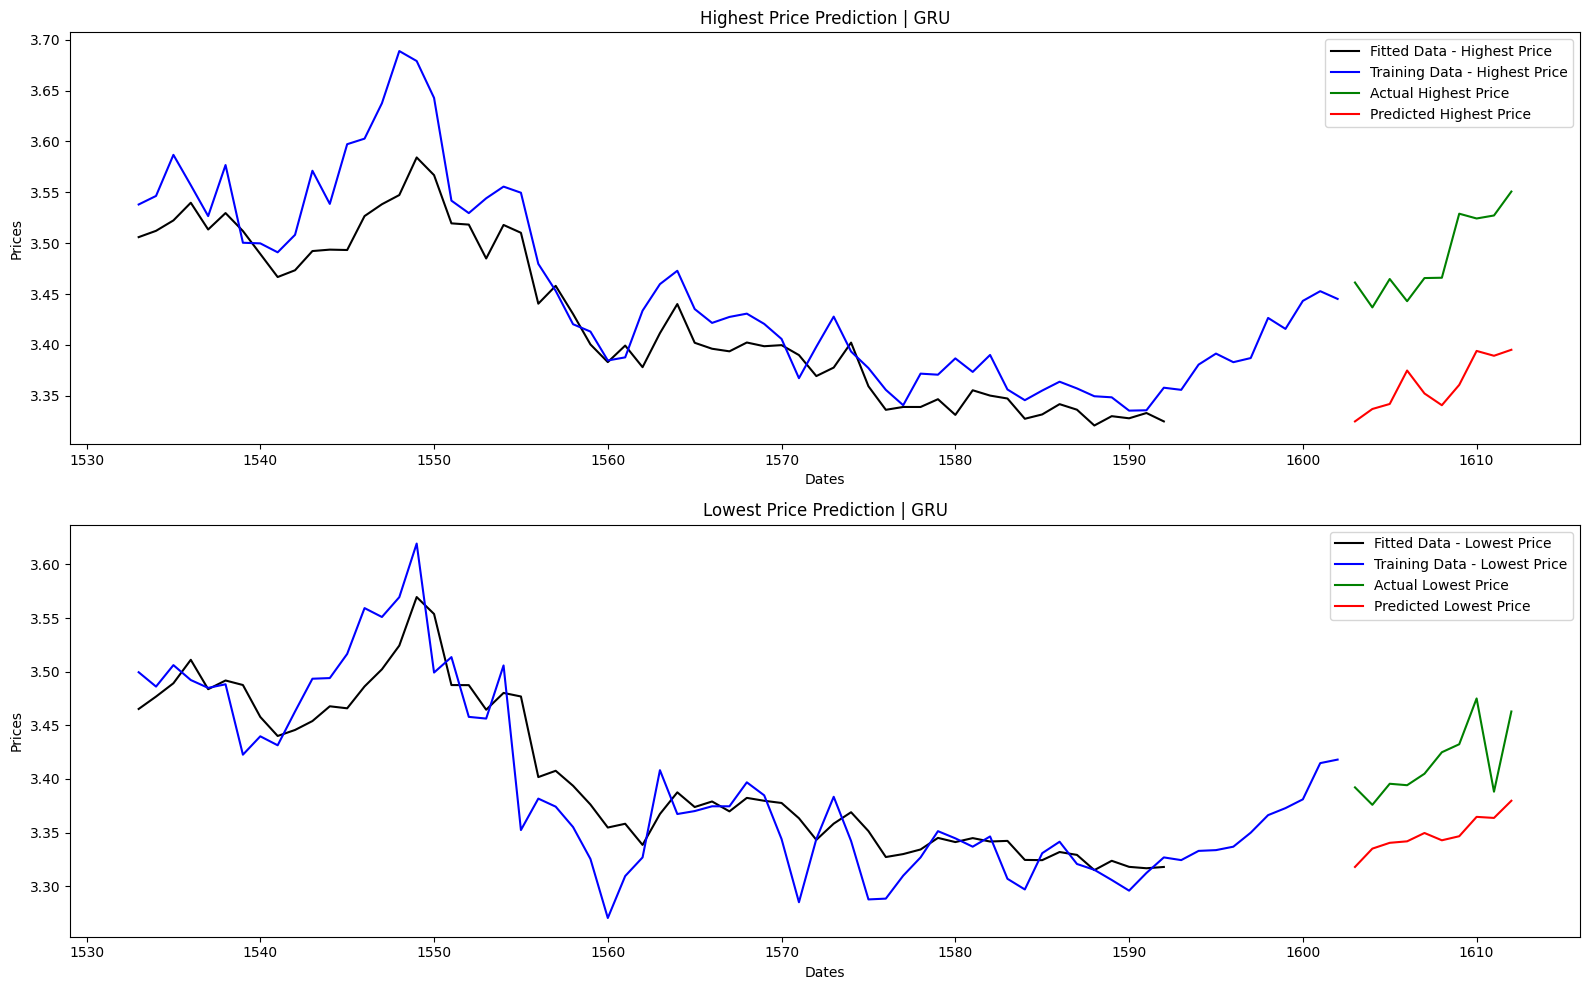

In [941]:
plt.figure(figsize=(16, 10))

# Plot highest price subplot
plt.subplot(2, 1, 1)
plt.plot(fitted_value_high_gru[-60:], color='black', label='Fitted Data - Highest Price')
plt.plot(training_set_high[-70:], color='blue', label='Training Data - Highest Price')
plt.plot(testing_set_high, color='green', label='Actual Highest Price')
plt.plot(predicted_value_high_gru, color='red', label='Predicted Highest Price')
plt.title('Highest Price Prediction | GRU')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Plot lowest price subplot
plt.subplot(2, 1, 2)
plt.plot(fitted_value_low_gru[-60:], color='black', label='Fitted Data - Lowest Price')
plt.plot(training_set_low[-70:], color='blue', label='Training Data - Lowest Price')
plt.plot(testing_set_low, color='green', label='Actual Lowest Price')
plt.plot(predicted_value_low_gru, color='red', label='Predicted Lowest Price')
plt.title('Lowest Price Prediction | GRU')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()



plt.tight_layout()
plt.show()



In [942]:
# Calculate Testing Mean Absolute Error (MAE high)
mae_high_test_GRU = mean_absolute_error(predicted_value_high_gru, testing_set_high)
print('Testing Mean Absolute Error highest:', mae_high_test_GRU)

# Calculate R^2 score testing (high)
r2_high_test_GRU = r2_score(predicted_value_high_gru, testing_set_high)
print('Testing R^2 Score highest: ', r2_high_test_GRU)

# Calculate Testing Mean Absolute Error (MAE low)
mae_low_test_GRU = mean_absolute_error(predicted_value_low_gru, testing_set_low)
print('Testing Mean Absolute Error lowest:', mae_low_test_GRU)

# Calculate R^2 score testing (low)
r2_low_test_GRU = r2_score(predicted_value_low_gru, testing_set_low)
print('Testing R^2 Score lowest: ', r2_low_test_GRU)



Testing Mean Absolute Error highest: 0.1258067993146596
Testing R^2 Score highest:  -26.592666485925257
Testing Mean Absolute Error lowest: 0.06637805594504335
Testing R^2 Score lowest:  -17.295259325072955


We can see that both LSTM and GRU failed to predict the future price of cryptocurrency, even cannot portray the trend of price.

# Model Comparison

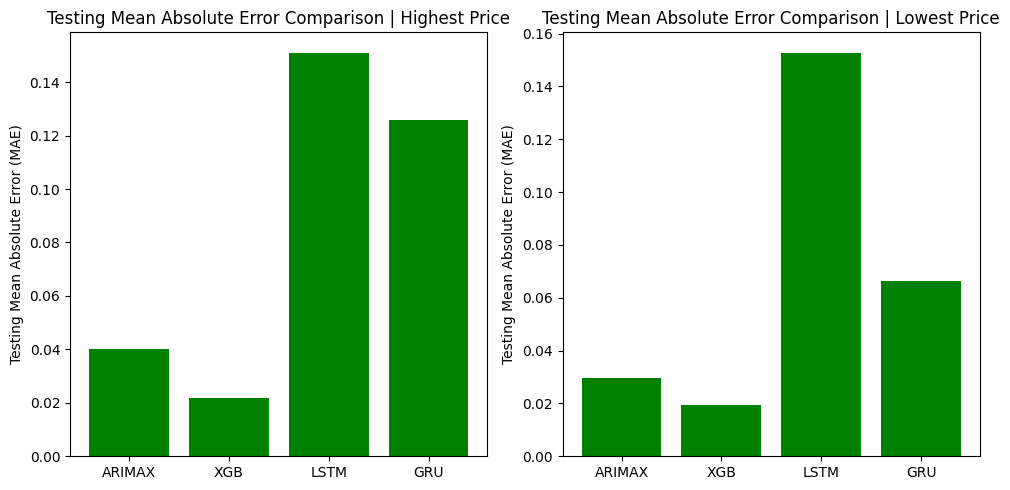

In [943]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot for highest price comparison
axs[0].bar(['ARIMAX', 'XGB', 'LSTM', 'GRU'], [mae_high_test_ARIMA, mae_high_test_XGB, mae_high_test_LSTM, mae_high_test_GRU], color='green', )
axs[0].set_ylabel('Testing Mean Absolute Error (MAE)')
axs[0].set_title('Testing Mean Absolute Error Comparison | Highest Price')

# Plot for lowest price comparison
axs[1].bar(['ARIMAX', 'XGB', 'LSTM', 'GRU'], [mae_low_test_ARIMA, mae_low_test_XGB, mae_low_test_LSTM, mae_low_test_GRU], color='green')
axs[1].set_ylabel('Testing Mean Absolute Error (MAE)')
axs[1].set_title('Testing Mean Absolute Error Comparison | Lowest Price')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Prediction of the price for next 10 days

Due to the unsatisfactory performance of LSTM and GRU, they will not be included in the final prediction.

# ARIMA

In [944]:
# highest prece prediction
inputs_ARIMA_high = pd.concat([shifted_training_set_high, testing_set_high])
inputs_ARIMA_high = pd.DataFrame(inputs_ARIMA_high)
exog_var_train_high.index = exog_var_train_high.index + len(exog_var_test_high)
exog_ARIMA_train = exog_var_train_high
exog_var_test_high.index = exog_var_test_high.index + len(exog_var_test_high)
exog_ARIMA_predict = exog_var_test_high

# Predict the price of len(testing_set) days using the fitted model
predictions_high_ARIMA = model_high_fit.forecast(steps=len(testing_set_high), exog = exog_ARIMA_predict.iloc[-len(exog_var_test_high):])


In [945]:
# lowest prece prediction
inputs_ARIMA_low = pd.concat([shifted_training_set_low, testing_set_low])
inputs_ARIMA_low = pd.DataFrame(inputs_ARIMA_low)
exog_var_train_low.index = exog_var_train_low.index + len(exog_var_test_low)
exog_ARIMA_train = exog_var_train_low
exog_var_test_low.index = exog_var_test_low.index + len(exog_var_test_low)
exog_ARIMA_predict = exog_var_test_low

# Predict the price of len(testing_set) days using the fitted model
predictions_low_ARIMA = model_low_fit.forecast(steps=len(testing_set_low), exog = exog_ARIMA_predict.iloc[-len(exog_var_test_low):])

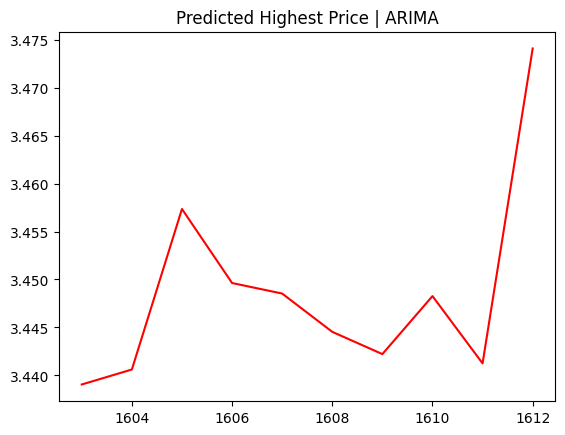

In [946]:
plt.plot(predictions_high_ARIMA.index, predictions_high_ARIMA, color='red')
plt.title('Predicted Highest Price | ARIMA')
plt.show()


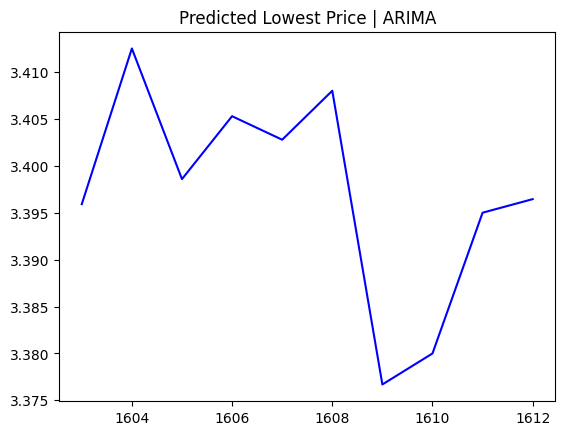

In [947]:
plt.plot(predictions_low_ARIMA.index, predictions_low_ARIMA, color='blue')
plt.title('Predicted Lowest Price | ARIMA')
plt.show()



# XGBoost

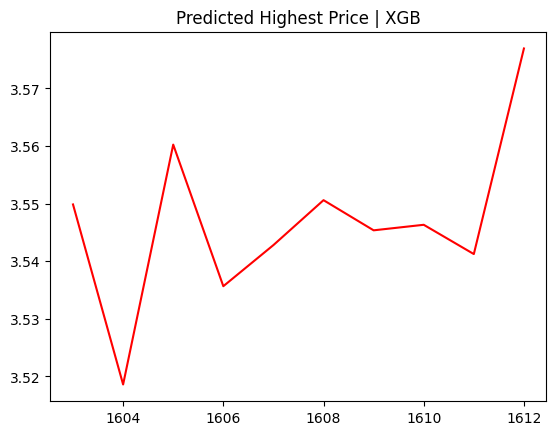

In [948]:
# highest price prediction
inputs_XGB_high = pd.concat([X_train_high, X_test_high])
inputs_XGB_high = pd.DataFrame(inputs_XGB_high)
output_XGB_high = model_xgb_high.predict(used_data_xgb_high[-test_size:])

plt.plot(predictions_high_ARIMA.index, output_XGB_high, color='red')
plt.title('Predicted Highest Price | XGB')
plt.show()


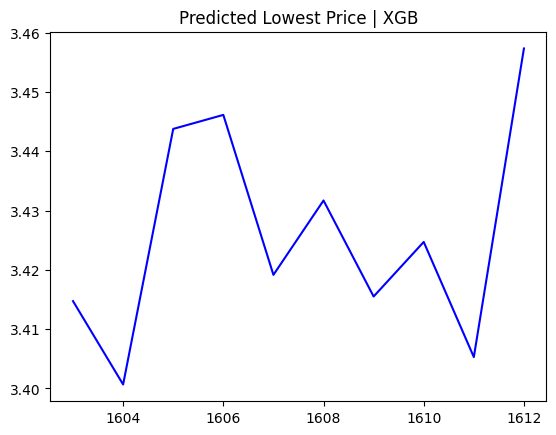

In [949]:
# lowest price prediction
inputs_XGB_low = pd.concat([X_train_low, X_test_low])
inputs_XGB_low = pd.DataFrame(inputs_XGB_low)
output_XGB_low = model_xgb_low.predict(used_data_xgb_low[-test_size:])

plt.plot(predictions_low_ARIMA.index, output_XGB_low, color='blue')
plt.title('Predicted Lowest Price | XGB')
plt.show()



# Final Prediction

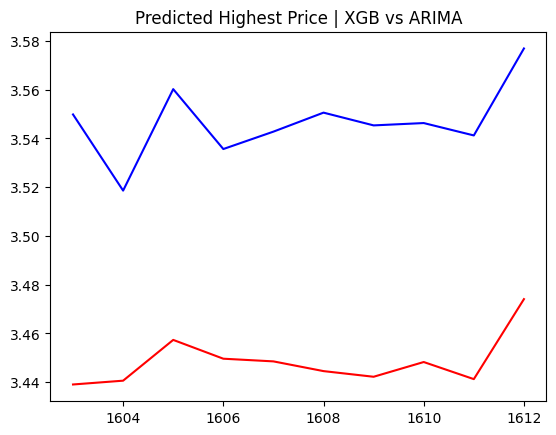

In [950]:
plt.plot(predictions_high_ARIMA.index, output_XGB_high, color='blue', label='XGB')
plt.plot(predictions_high_ARIMA.index, predictions_high_ARIMA, color='red', label='ARIMA')
plt.title('Predicted Highest Price | XGB vs ARIMA')
plt.show()

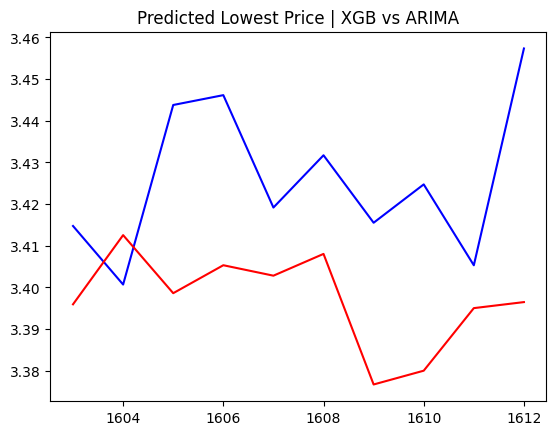

In [951]:
plt.plot(predictions_low_ARIMA.index, output_XGB_low, color='blue', label='XGB')
plt.plot(predictions_low_ARIMA.index, predictions_low_ARIMA, color='red', label='ARIMA')
plt.title('Predicted Lowest Price | XGB vs ARIMA')
plt.show()

Compute weight averaged predicted price & Apply exponential transformation

By comparison, XGB has more robust performance, thus we choose it as the final model.

In [952]:
# Invert the log transformation

highest_price_prediction = 1 * (np.exp(output_XGB_high) - 1) + 0 * (np.exp(predictions_high_ARIMA) - 1)

In [953]:
lowest_price_prediction = 1 * (np.exp(output_XGB_low) -1) + 0 * (np.exp(predictions_low_ARIMA) - 1)

In [954]:
# align the output index with the requirement
highest_price_prediction.index = highest_price_prediction.index + 1

In [955]:
lowest_price_prediction.index = lowest_price_prediction.index + 1

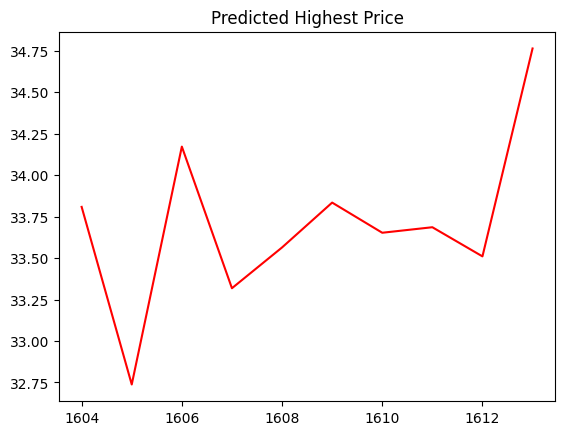

In [956]:
# pridected prices
plt.plot(highest_price_prediction.index, highest_price_prediction, color='red')
plt.title('Predicted Highest Price')
plt.show()

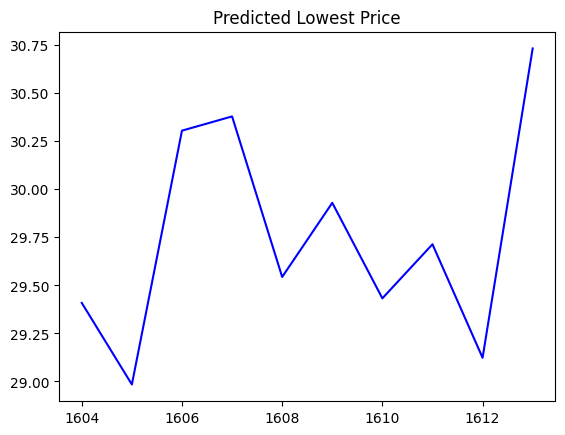

In [957]:
plt.plot(lowest_price_prediction.index, lowest_price_prediction, color='blue')
plt.title('Predicted Lowest Price')
plt.show()

# Download csv files

CryptoA_10Day.csv

In [958]:
import pandas as pd
from IPython import get_ipython
from IPython import get_ipython
from IPython.display import FileLink
# CryptoA_10Day.csv
# Create a dictionary with the data
data1 = {
    'obs': highest_price_prediction.index,
    'high_fiat': highest_price_prediction,
    'low_fiat': lowest_price_prediction
}

# Create a DataFrame from the dictionary
CryptoA_10Day_csv = pd.DataFrame(data1)

# Save the DataFrame to a CSV file
CryptoA_10Day_csv.to_csv('CryptoA_10Day.csv', index=False)

get_ipython().run_line_magic('pip', 'install IPython')

CryptoA_10Day_csv.to_csv('CryptoA_10Day.csv', index=False)
FileLink('CryptoA_10Day.csv')



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/yikuanli/Downloads/CryptoA_10Day.csv

High_Low.csv

In [959]:
# High_Low.csv
# Create a dictionary with the data
data2 = {
    'high_fiat': highest_price_prediction.max(),
    'low_fiat': lowest_price_prediction.min()
}

# Create a DataFrame from the dictionary
High_Low_csv = pd.DataFrame(data2, index=[0])

# Save the DataFrame to a CSV file

get_ipython().run_line_magic('pip', 'install IPython')

High_Low_csv.to_csv('High_Low.csv', index=False)
FileLink('High_Low.csv')


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/yikuanli/Downloads/High_Low.csv